<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import ridge_regression
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np
import copy

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (d, d) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (d * n, d)
        n, d = X.shape
        q = compute_q(p)

        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(d)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", n," ", d)
        print("y shape", y.shape)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", d*n)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        #if np.sum(S_mis * S_mis) == 0:
        if np.all(S_dict['S_mis'] == 0):
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        else:  # S_mis.shape == (n, d, d):
          S_dts_tiled = np.concatenate([S_dts] * n)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (d, d):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (d * n, d):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (n, d), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / n * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []

# dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}
def get_path(X, y, estimator, S_dict): #eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
    _, m = X.shape

    if S_dict['algo_superv_learn'] == 'adv':
      n_a_dts = S_dict['n_a_dts']
      a_d_dts_max = S_dict['adv_rad_times_delta_dts_max']
      a_d_dts_min = a_d_dts_max * S_dict['eps_adv_rad_times_delta_dts']
      if np.all(S_dict['S_mis'] == 0):
        n_a_mis, a_d_mis_max, a_d_mis_min = 1, 0, 0
      else:
        n_a_mis = S_dict['n_a_mis']
        a_d_mis_max = S_dict['adv_rad_times_delta_mis_max']
        a_d_mis_min = a_d_mis_max * S_dict['eps_adv_rad_times_delta_mis']


      if a_d_dts_max < 0 or a_d_mis_max < 0 or n_a_dts < 1 or n_a_mis <1:
        print("WARNING: some bad values for the grid of cross validation, the number of grid point should be strictly potive, the radius strictly positive")
      alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts) if a_d_dts_max > 0 else np.zeros(1)
      alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis) if a_d_mis_max > 0 else np.zeros(1)
      #alphas_dts = np.logspace(np.log10(a_d_dts_min), np.log10(a_d_dts_max), n_a_dts)
      #alphas_mis = np.logspace(np.log10(a_d_mis_min), np.log10(a_d_mis_max), n_a_mis)
      print("dts deltas ", alphas_dts)
      print("mis deltas ", alphas_mis)
      #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
      hyper_p_ret_ = []
      coefs_ = []
      for a_mis_value in tqdm.tqdm(alphas_mis):
        for a_dts_value in tqdm.tqdm(alphas_dts):
            #tuple_key = (scale_dts_value, scale_mis_value)
            #coefs_ = []
            #for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
              #print("dict hyper in get path ", dict_hyper_p_values)
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a_dts_value, a_mis_value])
            #res[tuple_key] = np.stack((coefs_)).T
    elif S_dict['algo_superv_learn'] == 'ridge':
      n_a_rid = S_dict['n_a_rid']
      a_rid_max = S_dict['alpha_ridge_reg_max']
      a_rid_min = a_rid_max * S_dict['eps_alpha_ridge_reg']
      alphas_rid = np.logspace(np.log10(a_rid_min), np.log10(a_rid_max), n_a_rid) if a_rid_max > 0 else np.zeros(1)
      print("rid alphas ", alphas_rid)
      hyper_p_ret_ = []
      coefs_ = []
      print("S_dts_inv in get path, ridge regression \n", S_dict['S_dts'])
      S_dts_inv = np.linalg.inv(S_dict['S_dts'])  # (d, d)
      print("S_dts_inv in get path, ridge regression \n", S_dts_inv)
      for a_rid in tqdm.tqdm(alphas_rid):
            #dict_hyper_p_values = {'adv_radius_times_dts': a_dts_value, 'adv_radius_times_mis': a_mis_value}
            #print("dict hyper in get path ", dict_hyper_p_values)
            coefs = estimator(X @ S_dts_inv, y, a_rid)
            coefs = S_dts_inv @ coefs
            #print("alpha  ", a, "coef: ", coefs)
            coefs_.append(coefs if coefs is not None else np.zeros(m))
            hyper_p_ret_.append([a_rid, a_rid])  #([a_dts_value, a_mis_value])


    '''
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    '''
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

#dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'alpha_ridge_reg': 1,
#                             'eps_adv_rad_times_delta_dts': 1e-4, 'eps_adv_rad_times_delta_mis': 1e-4, 'eps_alpha_ridge_reg': 1e-4,
#                             'n_a_dts': 25, 'n_a_mis':4, 'n_a_rid': 25}}





'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):

    if S_dict['algo_superv_learn'] == 'adv':
      linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
      estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
    elif S_dict['algo_superv_learn'] == 'ridge':
      estimator = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False)#, random_state=0)
      hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, S_dict)
      #estimator = lambda X, y, a: linear_model.Ridge(alpha=a).fit(X, y).coef_
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf


X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)

alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=True, random_state=0)
for a in alphas:
  coef, intercept = estim(X, y, a)
  print("coef : ", coef)
  print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  print("coef : ", coef)
  print("intercpt ", intercept)


'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
coef :  [ 1.98067776 -1.00996959  0.00379405  0.00497174]
intercpt  -0.002254597357085329
coef :  [ 1.98067776 -1.00996959  0.00379405  0.00497174]
intercpt  -0.002254597357085329
coef :  [ 1.98065891 -1.00996134  0.00379433  0.00497553]
intercpt  -0.0022541906694196682
coef :  [ 1.98065891 -1.00996134  0.00379433  0.00497553]
intercpt  -0.0022541906694196682
coef :  [ 1.97877575 -1.00913783  0.00382202  0.00535497]
intercpt  -0.002214339993532218
coef :  [ 1.97877575 -1.00913783  0.00382202  0.00535497]
intercpt  -0.002214339993532218
coef :  [ 1.96185973 -1.00179863  0.00409157  0.00869871]
intercpt  -0.0018662227776724979
coef :  [ 1.96185973 -1.00179863  0.00409157  0.00869871]
intercpt  -0.0018662227776724979
end block


In [25]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  print("X shape in clear data ", X.shape)
  print("y shape in clear data ", y.shape)
  print("M shape in clear data ", M.shape)
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 100000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [19]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
'''
def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks
'''

def generate_masks(dictio_data):#nbr_of_sample, dim, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    dim = len(dictio_data['beta_gt'][0])
    nbr_of_sample = dictio_data['n_train'][-1]  # last one should be the biggest one
    p_missing = dictio_data['p_miss'][0]
    print("p_missing in generate mask ", p_missing)
    if dim == 2:
      if len(p_missing) < 3:
        print("WARNING: p_missing should be a list with a length of 3 if the dimension is 2")
      masks = np.zeros((nbr_of_sample, 2))
      v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
      masks[v == 0, :] = np.array([0, 0])  # both seen
      masks[v == 1, :] = np.array([0, 1])  # left seen
      masks[v == 2, :] = np.array([1, 0])  # right seen
    else:
      # in this branch, p_missing = [p1,.., pl],
      masks = np.array([np.random.binomial(1, 1-pr, (nbr_of_sample, dim)) for pr in p_missing])
      masks = np.cumsum(masks, axis=0)  # each round
      masks[masks>1] = 1
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + -1 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [20]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)  # size (info['mi_nbr], n, d)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:
      if info['cov_strategy'] == 'std_mi':   # std of the imputed dataset, then the mean
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        #s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = std_vectors[:, None, :] * np.eye(std_vectors.shape[-1])  # should be (m, d, d), with each diagonal the diagonals of std_vectors
        #S = s_within
        #S = np.diag(s_within)
        print("final S.shape in cov strategy std_mi ", S.shape)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure'] and 'cov_strategy_between' in info.keys():
      m, n, d = X_imputed.shape
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
        if info['post_imp'] == 'conc':
          S_mis = np.tile(S_mis, (m, 1, 1))
    else:  # not using a mi method, so uncertainty on missing part should be zero
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      print("shape X_imputed ", X_imputed.shape)
      X_train = np.concatenate(X_imputed)
      y_train = np.tile(y_train, X_imputed.shape[0])
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      if len(beta_gt) != len(data['mean']) or len(beta_gt) != data['cov'].shape[0]:
        print("ERROR: DIMENSION MISSMATCH")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim) -0.5
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    elif err['type'] == 'Uniform_on_X':
      error = ((np.random.rand(n_tot, dim)-0.5) @ beta_gt) * err['scaling']
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    # masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    # masks_train = generate_masks_binomial(n_train, p_miss)  # 1 missing, 0 observed
    #X_train, y_train, masks_train = clear_dataset(X_train, y_train, masks_train)
    # M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    # dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, []), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      print("NO PREVIOUS IMPUTATION HAS BEEN DONE")
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      print("A PREVIOUS IMPUTATION HAS BEEN DONE")
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) #* dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  #* dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    if 'post_imp' in dict_obs.keys():
      if dict_obs['post_imp'] == 'conc':
        print(S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing} | dict_obs['info_algo'] | {'algo_superv_learn': dict_imp['algo_superv_learn']}  # , 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    # dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 1, 'adv_rad_times_delta_mis_max': 1, 'eps_adv_rad_times_delta_dts': 1e-4 'eps_adv_rad_times_delta_dts': 1e-4}}

    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi' and dict_imp['cov_strategy'] == 'std_mi':  # run a standard multiple imputation procedure
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      min_score = 0
      temporary_dictionary = copy.deepcopy(S_dict)
      for i in range(dict_imp['mi_nbr']):
        print("i  mi .-------------> ", i)
        #dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        #dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        #S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        #S = S_within[None, :, :] + S_between
        #S = np.concatenate(S, axis=0)
        #print(S)
        #alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        temporary_dictionary['S_dts'] = S_dict['S_dts'][i, :, :]
        print("temporary dict ", temporary_dictionary)
        hyper_p_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, temporary_dictionary, [])
        idx_best, min_score_partial = best_idx_predictor(X_test, coeff_results, y_test)
        print("weee ", idx_best)
        print(coeff_results.shape)
        print(hyper_p_used.shape)
        best_coeff_partial, _ = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        min_score += min_score_partial
        #best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
      best_coeff /= dict_imp['mi_nbr']
      min_score /=  dict_imp['mi_nbr']
      best_hyper_p = 0  # not important right now
      best_alpha_delta_dts = 1  # not important right now
      #best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha_delta_dts, best_alpha_delta_mis = best_hyper_p[0], best_hyper_p[1]
#     print("best alpha ----> ", best_alpha_dts)
      if len(ax) > 0:
        ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
        ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
        #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
        # 'multip_betw': 1, 'multip_with':1
        ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
        S_plot = S_dict['S_dts'] * best_alpha_delta_dts + S_dict['S_mis'] * best_alpha_delta_mis
        #print("S_plot ", S_plot)
        add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
        ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
    #print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])


    # obsere that one day you shoul add the return of alpha_delta_mis also
    return best_coeff, min_score, -np.log10((best_alpha_delta_dts + best_alpha_delta_mis)/2)



In [36]:
def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])  # how many trials shall we do
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed  = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][-1],  # last one should be the biggest
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][-1],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0]
                                             )  # return {'X_train_masked':(X_train, mask_train) , 'X_test':.., 'y_train':, 'y_test'}
      #mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen
      full_masks = generate_masks(dictio)
    dictio_obser_fixed_copy = copy.deepcopy(dictio_obser_fixed)

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        if len(dictio['beta_gt'][0]) == 2:
          #mask_partial = dict_obser_partial['X_train_masked'][1]
          p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
          n_train = full_masks.shape[0]
          mask_partial = full_masks.copy()
          mask_partial[0:int(n_train * p_i), :] = 0
          tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
          dict_obser['X_train_masked'] = tuple_partial
        else:
          #print("size in run experiment", dictio_obser_fixed_copy['X_train_masked'][0].shape, "wee ", dictio_obser_fixed['y_train'].shape)
          ## we use the next line of code with dictio_obser_fixed_copy because we need to test the mask with the original dataset, otherwise we get size error (the dataset change if an observation get fully hidden)
          n_train = dictio['n_train']
          print("n_tot_fll ", n_train, ",  ", n_train[i])
          #print(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :].shape)
          #print(dictio_obser_fixed_copy['X_train_masked'][0].shape)
          X_train_cleaned, y_train_cleaned, masks_train_cleaned = clear_dataset(dictio_obser_fixed_copy['X_train_masked'][0][0:n_train[i], :], dictio_obser_fixed_copy['y_train'][0:n_train[i]], full_masks[i][0:n_train[i], :])
          print("shapes X_train cleaned, mask train cleaned, y train cleaned")
          print(X_train_cleaned.shape)
          print(masks_train_cleaned.shape)
          print(y_train_cleaned.shape)
          #tuple_partial = (dictio_obser_fixed['X_train_masked'][0], full_masks[i])
          print("full masks in run experiment ", full_masks[i])
          dict_obser['X_train_masked'] = (X_train_cleaned, masks_train_cleaned)
          dict_obser['y_train'] = y_train_cleaned
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      print("info algo in run experiments ", dictio['info_algo'])
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}} | {'info_algo': dictio['info_algo']}  # add an entry for imputed dataset, and info for algorithm
      print("ciaoooooo dict obser in run experiments \n ", dict_obser)
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        if nbr_ima > 0:
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        else:  # == 0
          coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, [])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  #ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  #ax_res[0].set_title('n_test: ' + str(n_test) + extra_info['title_infer_error'])
  #ax_res[1].set_title('n_test: ' + str(n_test) + extra_info['title_test_error'])
  ax_res[0].set_title(extra_info['title_infer_error'])
  ax_res[1].set_title(extra_info['title_test_error'])
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio


def run_multiple_experiments(nbr_exp, rdm_seed, dictio, info_x_axis):
  #rdm_seed = 4654321
  np.random.seed(rdm_seed)
  res = run_experiments(dicc, list_methods_strategy)
  plot_res(info_x_axis, res, dicc)
  '''
  if nbr_exp > 1:
    for k in res:
      for h in res[k]:
        res[k][h] = [res[k][h]]
    for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])
  '''
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
      print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
      #np.random.seed(rdm_seed * (i+2))
      res_partial = run_experiments(dictio, list_methods_strategy)
      plot_res(info_x_axis, res_partial, dictio)
      print(res)
      for k in res:
        res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
        res[k]['best_score'].append(res_partial[k]['best_score'])
        res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
        #res[k]['best_coeff'].append(res_partial[k]['best_coeff
        #res.append(res['l2_dist_best_coeff_gt'])

  print("final step, let's take the mean of the results")
  #print("res, after all the experimetns ", res)
  for k in res:
    print("key in res ", k)
    print(np.array(res[k]['l2_dist_best_coeff_gt']))
    print("mean l2_dist              ", np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
    print("mean_l2_dist diff method: ", np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
  #mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
  mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
  print("final dictionary, dictionary of the means:")
  for k, v in mean_res.items():
    print("k:   ", k)
    for s, t in v.items():
      print(s, ": ", t)
  return mean_res
  #print(np.mean(res, axis=0))




[-1.84238169 -1.40002876 -1.85592998 -0.72381304  0.72744014 -0.3636755
  0.96898292  0.30526237  0.64852114 -0.43623839 -0.68168441  0.13720578]
change nbr_experiments to match the size of n_train
data :  [{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23603849e+00,  2.19450198e+00,  1.06725424e+01,
        -2.74805210e+00,  1.62315643e+01, -2.21519830e+01],
       [ 6.14930891e+00, -8.11997658e+00,  4.75986031e+01,
        -2.34590230e+01, -4.99544914e-01,  7.88108238e+00,
         2.71024056e+01, -1.55449720e+01, -6.21169346e+00,
        -1.19855941e+01,  2.29162663e+00,  8.76225252e+00],
  

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  13.805053167506259
[5 6 5 5 4 5 4 5 4 3 4 5 6 5 7 8 6 5 6 6 5 6 4 3 5 3 5 5 4 1 3 5 6 3 5 4 7
 4 1 4 4 5 4 4 5 7 4 6 5 6 4 5 6 5 4 3 3 6 3 5 4 5 5 1 5 6 6 6 3 3 3 6 7 5
 3 5 5 2 4 5 8 3 4 5 5 6 5 6 5 7 5 3 4 6 4 4 6 3 6 4]
S dataset 
 [[0.26263211 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.26694518 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29046707 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.31097817 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28066415 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.        ] , min score  13.266802335779712
---------------------------------> best coeff  [ 4.84499127e-12  1.24569450e-12 -7.80802373e-11 -1.80949203e-10
  1.80149203e-10 -2.55495018e-11 -2.16746007e-11  3.34792198e-11
  8.09324777e-01  7.80851572e-11  4.15402185e-12  1.60354503e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26399096 0.28246797 0.29105501 0.29248562 0.27952565 0.2839465
 0.2938551  0.29058674 0.27831719 0.31019347 0.28073651 0.24854746]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  14.702647730339637
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.694618449685137
---------------------------------> best coeff  [-8.67700412e-01 -1.02663495e+00 -1.65321959e+00 -1.07678251e+00
  6.34502968e-01  3.39162331e-08  5.97907931e-08  3.45529569e-11
  1.52481830e+00 -1.91292709e-10 -9.52789554e-01  1.23626106e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26399096 0.28246797 0.29105501 0.29248562 0.27952565 0.2839465
 0.2938551  0.29058674 0.27831719 0.31019347 0.28073651 0.24854746]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.805053167506259
[5 6 5 5 4 5 4 5 4 3 4 5 6 5 7 8 6 5 6 6 5 6 4 3 5 3 5 5 4 

100%|██████████| 40/40 [00:00<00:00, 1293.63it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.68803783390327
---------------------------------> best coeff  [ 0.31859373 -1.12412779 -1.03878006 -0.7739854   0.99961228  0.30258325
 -0.21775753 -0.07915044  2.94555152  0.97349911  0.35539559  0.7225514 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26399096 0.28246797 0.29105501 0.29248562 0.27952565 0.2839465
 0.2938551  0.29058674 0.27831719 0.31019347 0.28073651 0.24854746]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  14.702647730339637
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1104.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.670896311918849
---------------------------------> best coeff  [-1.02830632 -1.23718927 -1.71254813 -1.27047241  0.80148472  0.22942773
  0.20872749  0.04487019  1.60271811 -0.05306877 -1.12387311  1.24019434]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  23.42652053531559
[5 6 5 5 4 5 4 5 4 3 4 5 6 5 7 8 6 5 6 6 5 6 4 3 5 3 5 5 4 1 3 5 6 3 5 4 7
 4 1 4 4 5 4 4 5 7 4 6 5 6 4 5 6 5 4 3 3 6 3 5 4 5 5 1 5 6 6 6 3 3 3 6 7 5
 3 5 5 2 4 5 8 3 4 5 5 6 5 6 5 7 5 3 4 6 4 4 6 3 6 4 5 7 4 7 4 6 6 5 3 7 6
 7 3 2 5 4 5 4 6 4 5 4 4 6 7 5 6 2 6 6 4 4 4 2 3 3 5 5 8 5 5 3 5 5 4 0 8 2
 3 4]
S dataset 
 [[0.27415949 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.26741069 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29417584 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.31463766 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.27624098 0.
  0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  13.064114941662686
---------------------------------> best coeff  [-3.54729561e-09 -1.43207662e-09 -8.71056057e-01 -4.09357526e-01
  5.37761527e-10 -8.17685751e-10 -3.05889519e-10 -2.22094209e-10
  1.09343136e+00  1.44458064e-01 -3.47761708e-09 -1.00870937e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27230722 0.28018637 0.29452796 0.29854413 0.28269155 0.29523727
 0.28766523 0.28651328 0.28157553 0.30383469 0.29217436 0.26242133]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.36477704299017
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  12.53558920105785
---------------------------------> best coeff  [-0.84315047 -1.08121842 -2.08908258 -1.11181967  0.32313964  0.38218549
  0.6618045   0.43795806  1.05423727  0.08984562 -0.6040351   0.55923285]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27230722 0.28018637 0.29452796 0.29854413 0.28269155 0.29523727
 0.28766523 0.28651328 0.28157553 0.30383469 0.29217436 0.26242133]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  23.42652053531559
[5 6 5 5 4 5 4 5 4 3 4 5 6 5 7 8 6 5 6 6 5 6 4 3 5 3 5 5 4 1 3 5 6 3 5 4 7
 4 1 4 4 5 4 4 5 7 4 6 5 6 4 5 6 5

100%|██████████| 40/40 [00:00<00:00, 1101.40it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.170357434058683
---------------------------------> best coeff  [-0.49113477 -0.57315674 -2.18307687 -1.69659815 -0.57481184 -0.35908967
  0.74555358 -0.2444643   1.89527696  1.27874766 -1.2150513   0.1815614 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27230722 0.28018637 0.29452796 0.29854413 0.28269155 0.29523727
 0.28766523 0.28651328 0.28157553 0.30383469 0.29217436 0.26242133]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.36477704299017
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1044.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.56016722436713
---------------------------------> best coeff  [-0.95382294 -1.18719652 -2.07542827 -1.19476844  0.40346095  0.53714135
  0.79618424  0.5612268   1.17297322  0.22152912 -0.72364472  0.67012847]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  35.13733496840043
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6  6  5  6  4  3
  5  3  5  5  4  1  3  5  6  3  5  4  7  4  1  4  4  5  4  4  5  7  4  6
  5  6  4  5  6  5  4  3  3  6  3  5  4  5  5  1  5  6  6  6  3  3  3  6
  7  5  3  5  5  2  4  5  8  3  4  5  5  6  5  6  5  7  5  3  4  6  4  4
  6  3  6  4  5  7  4  7  4  6  6  5  3  7  6  7  3  2  5  4  5  4  6  4
  5  4  4  6  7  5  6  2  6  6  4  4  4  2  3  3  5  5  8  5  5  3  5  5
  4  0  8  2  3  4  8  4  2  6  8  7  5  5  6  8  4  6  4  5  5  8  6  6
  7  6  6  4  8  4  4  5  5  3  6  2  4  2  4  4  5  9  4  4  5  3  9  9
  2  5  2  4  8 10  3  5]
S dataset 
 [[0.27956981 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.26672392 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.2902808  0.   

100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  27  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.28942661 0.        ] , min score  13.297051132937638
---------------------------------> best coeff  [-9.17790928e-12  2.53307685e-12 -1.17375151e-11 -1.67892608e-11
  1.30232903e-11 -5.50443132e-12  3.84541167e-12  6.49558072e-12
  3.51758530e-10  1.25827221e-10 -1.20355745e-11  1.22708750e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27984496 0.28103953 0.28796262 0.28967577 0.28395683 0.29462592
 0.28338656 0.28880728 0.28205495 0.29177585 0.28487783 0.27388198]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.097159913738757
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.7424249411467
---------------------------------> best coeff  [-8.20319113e-01 -4.20265422e-01 -1.64396683e+00 -6.01600655e-01
  5.64140940e-09  1.19353843e-09  3.62560952e-01  5.83897338e-01
  1.59447854e+00  4.11936931e-01 -9.73138056e-01  8.24253855e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27984496 0.28103953 0.28796262 0.28967577 0.28395683 0.29462592
 0.28338656 0.28880728 0.28205495 0.29177585 0.28487783 0.27388198]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  35.13733496840043
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6  6 

100%|██████████| 40/40 [00:00<00:00, 1165.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.509285190781982
---------------------------------> best coeff  [-0.1191843   0.12171824 -1.28692397 -1.33749058 -1.53443473 -1.18059457
  1.4218917  -0.52729318  3.32567909  1.84364923 -0.93026739  1.1651744 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27984496 0.28103953 0.28796262 0.28967577 0.28395683 0.29462592
 0.28338656 0.28880728 0.28205495 0.29177585 0.28487783 0.27388198]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.097159913738757
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1112.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.845491158733866
---------------------------------> best coeff  [-1.12148923 -0.86626077 -1.82640518 -0.92180843  0.22235486  0.20999828
  0.86654724  1.04651748  2.00414387  0.66356971 -1.41245655  1.18861646]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  13.846236380284957
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6  6  5  6  4  3
  5  3  5  5  4  1  3  5  6  3  5  4  7  4  1  4  4  5  4  4  5  7  4  6
  5  6  4  5  6  5  4  3  3  6  3  5  4  5  5  1  5  6  6  6  3  3  3  6
  7  5  3  5  5  2  4  5  8  3  4  5  5  6  5  6  5  7  5  3  4  6  4  4
  6  3  6  4  5  7  4  7  4  6  6  5  3  7  6  7  3  2  5  4  5  4  6  4
  5  4  4  6  7  5  6  2  6  6  4  4  4  2  3  3  5  5  8  5  5  3  5  5
  4  0  8  2  3  4  8  4  2  6  8  7  5  5  6  8  4  6  4  5  5  8  6  6
  7  6  6  4  8  4  4  5  5  3  6  2  4  2  4  4  5  9  4  4  5  3  9  9
  2  5  2  4  8 10  3  5  5  3  6  3  6  7  4  4  4  5  4  3  3  6  3  3
  4  5  6  5  4  6  5  4  3  9  7  6  2  5  3  4  4  7  5  5  4  3  5  3
  6  8  5  4  3  5  5  4  7  2]
S dataset 
 [[0.2802311  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.2

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  13.138659087947788
---------------------------------> best coeff  [-2.68043729e-10 -2.81856944e-09 -1.07610575e+00 -7.24925609e-01
 -4.17836994e-09 -1.90657033e-06  1.11824902e-09  8.82650462e-12
  5.59321637e-01  1.04307587e+00 -2.69106459e-01  7.90563680e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346529 0.27900986 0.28668463 0.29674592 0.28103142 0.28796181
 0.28407669 0.28584358 0.27748383 0.2894835  0.29267484 0.28082681]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.499925711788805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.6894232160484
---------------------------------> best coeff  [-2.37402570e-01 -8.85358883e-01 -2.18886707e+00 -1.33389876e+00
  8.51127914e-09 -8.15855823e-11  1.14112399e+00  5.97340245e-01
  9.85228150e-01  7.20677662e-10 -9.24721846e-01  4.41882739e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346529 0.27900986 0.28668463 0.29674592 0.28103142 0.28796181
 0.28407669 0.28584358 0.27748383 0.2894835  0.29267484 0.28082681]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  13.846236380284957
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6  6

100%|██████████| 40/40 [00:00<00:00, 1234.26it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.591566974871748
---------------------------------> best coeff  [-0.92557345 -0.90815685 -2.01580408 -1.35390726 -1.60501165 -1.81651163
  1.13752001 -0.46989883  1.99007916  1.26369748 -1.64299502  0.48046076]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28346529 0.27900986 0.28668463 0.29674592 0.28103142 0.28796181
 0.28407669 0.28584358 0.27748383 0.2894835  0.29267484 0.28082681]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.499925711788805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 443.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.812324153640784
---------------------------------> best coeff  [-0.61413925 -1.28755385 -2.46687616 -1.63411664  0.3414877  -0.04972036
  1.66183395  1.15065363  1.46162701  0.08233192 -1.38149936  0.86620352]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  22.476974473480965
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6  6  5  6  4  3
  5  3  5  5  4  1  3  5  6  3  5  4  7  4  1  4  4  5  4  4  5  7  4  6
  5  6  4  5  6  5  4  3  3  6  3  5  4  5  5  1  5  6  6  6  3  3  3  6
  7  5  3  5  5  2  4  5  8  3  4  5  5  6  5  6  5  7  5  3  4  6  4  4
  6  3  6  4  5  7  4  7  4  6  6  5  3  7  6  7  3  2  5  4  5  4  6  4
  5  4  4  6  7  5  6  2  6  6  4  4  4  2  3  3  5  5  8  5  5  3  5  5
  4  0  8  2  3  4  8  4  2  6  8  7  5  5  6  8  4  6  4  5  5  8  6  6
  7  6  6  4  8  4  4  5  5  3  6  2  4  2  4  4  5  9  4  4  5  3  9  9
  2  5  2  4  8 10  3  5  5  3  6  3  6  7  4  4  4  5  4  3  3  6  3  3
  4  5  6  5  4  6  5  4  3  9  7  6  2  5  3  4  4  7  5  5  4  3  5  3
  6  8  5  4  3  5  5  4  7  2  5  2  6  6  5  4  3  4  4  7  5  6  5  5
  5  7  8  5  5  6  4  7  3  4  9  7  6  3  4  4  2  4  3  5  5  3  3  3
  1  5  0  6  5  5  2  5  5  5  5  5]
S dat

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  13.002679554835442
---------------------------------> best coeff  [-3.05545022e-09 -3.04082649e-10 -1.19584517e+00 -4.54862853e-01
  1.08910159e-09 -3.61610291e-10  8.43837760e-10 -8.20243036e-11
  1.75104539e-01  3.25556213e-01 -3.36544546e-01  3.50328396e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28448821 0.271424   0.28683914 0.28998254 0.28852782 0.28892621
 0.2918743  0.28334945 0.28636851 0.28955067 0.29072921 0.28217172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.76214458079878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.712281609076276
---------------------------------> best coeff  [-3.13272540e-01 -6.59587158e-01 -2.30426444e+00 -1.27659639e+00
  9.90591297e-11  1.23356873e-08  7.96507021e-01  3.34282366e-01
  1.03134931e+00  6.08720610e-11 -9.24889349e-01  7.29224679e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28448821 0.271424   0.28683914 0.28998254 0.28852782 0.28892621
 0.2918743  0.28334945 0.28636851 0.28955067 0.29072921 0.28217172]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.476974473480965
[ 5  6  5  5  4  5  4  5  4  3  4  5  6  5  7  8  6  5  6 

100%|██████████| 40/40 [00:00<00:00, 663.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.136333586541033
---------------------------------> best coeff  [-0.84171922 -0.45816098 -2.32009351 -1.88236401 -0.09748269 -1.08177939
  0.97541159 -0.61178386  1.12564048  1.16148998 -2.05305684  0.47614547]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28448821 0.271424   0.28683914 0.28998254 0.28852782 0.28892621
 0.2918743  0.28334945 0.28636851 0.28955067 0.29072921 0.28217172]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.76214458079878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 966.68it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.799308856152155
---------------------------------> best coeff  [-0.66890222 -1.17203624 -2.6220802  -1.59664608  0.31597306  0.43975424
  1.20939338  0.8677525   1.40843426 -0.03416917 -1.25731783  1.09883378]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 4.84499127e-12,  1.24569450e-12, -7.80802373e-11, -1.80949203e-10,
        1.80149203e-10, -2.55495018e-11, -2.16746007e-11,  3.34792198e-11,
        8.09324777e-01,  7.80851572e-11,  4.15402185e-12,  1.60354503e-11]), array([-3.54729561e-09, -1.43207662e-09, -8.71056057e-01, -4.09357526e-01,
        5.37761527e-10, -8.17685751e-10, -3.05889519e-10, -2.22094209e-10,
        1.09343136e+00,  1.44458064e-01, -3.47761708e-09, -1.00870937e-09]), array([-9.17790928e

100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  30  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.70170383 0.        ] , min score  12.998091110677626
---------------------------------> best coeff  [-9.43956427e-12 -4.23762148e-12 -3.39671781e-12  2.67213814e-12
 -8.16262449e-12 -3.07950442e-12  7.93317382e-14 -7.25540340e-13
 -1.62610015e-12  2.42868471e-12 -1.81945742e-12  1.52994708e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28802939 0.28584972 0.27851941 0.29967533 0.28370007 0.29337598
 0.26773269 0.27160375 0.32759421 0.28560989 0.28713678 0.29830743]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.56365033476808
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  12.998091110649257
---------------------------------> best coeff  [-1.98306255e-11  1.13523615e-11 -1.01355335e-10 -1.50844187e-11
  1.36554474e-10 -6.10579382e-11  1.72209801e-10 -8.48192974e-10
  1.00545128e-10  1.19996063e-10  1.36606095e-10  3.02273545e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28802939 0.28584972 0.27851941 0.29967533 0.28370007 0.29337598
 0.26773269 0.27160375 0.32759421 0.28560989 0.28713678 0.29830743]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.12385368301302
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4

100%|██████████| 40/40 [00:00<00:00, 615.74it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  15.336564493723639
---------------------------------> best coeff  [ 2.08575607  0.80514335  0.3827564  -0.40875938  1.03429708  0.13268343
  0.82468669 -2.44525371  1.63813484  0.18388869  0.43995139 -2.04887283]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28802939 0.28584972 0.27851941 0.29967533 0.28370007 0.29337598
 0.26773269 0.27160375 0.32759421 0.28560989 0.28713678 0.29830743]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.56365033476808
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 571.36it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.396060579313113
---------------------------------> best coeff  [ 0.12596834  0.15326685 -0.78247282  0.16841746  0.90822535 -0.56611933
  0.91717857 -1.82029274  0.85320496  0.69878819  0.98942568  0.0984364 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -18.57009286471318
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4 4 3 6 5 7 7 7 5
 3 4 5 5 7 4 3 6 3 4 4 5 4 1 3 3 5 5 4 5 3 4 6 1 4 2 3 3 5 4 3 2 4 0 2 5 6
 4 2 6 5 6 5 3 2 7 4 4 5 4 6 3 7 4 2 4 7 4 3 5 3 6 5 3 6 8 6 6 6 9 6 6 5 8
 6 6 3 5 8 4 8 5 5 4 4 4 5 3 6 2 5 4 4 5 7 6 5 3 4 3 4 3 3 5 4 4 5 4 4 4 7
 8 2]
S dataset 
 [[0.27203324 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29498089 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30102995 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.29169725 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28012579 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  12.998091110341425
---------------------------------> best coeff  [-5.92800726e-10  1.45943370e-10 -8.82532285e-10 -2.21841021e-11
 -1.18015841e-11  2.76900074e-10  8.61745437e-11 -4.72559266e-09
  1.13343451e-09  8.41676210e-11 -1.86033926e-10 -6.43467492e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28263512 0.28534569 0.29327859 0.2861999  0.28557896 0.29704257
 0.28539662 0.27778724 0.32025939 0.28990937 0.29008551 0.30077872]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.9633627214496
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.84079283583897
---------------------------------> best coeff  [-3.11046546e-10 -3.01948567e-10 -9.26450529e-01 -8.27516589e-10
 -3.44623088e-11  1.42733384e-10  8.57803334e-02 -9.11414660e-01
  8.74976409e-01  2.71004739e-10 -3.83185561e-11  2.48747502e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28263512 0.28534569 0.29327859 0.2861999  0.28557896 0.29704257
 0.28539662 0.27778724 0.32025939 0.28990937 0.29008551 0.30077872]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.57009286471318
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4 

100%|██████████| 40/40 [00:00<00:00, 811.91it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.605500302835642
---------------------------------> best coeff  [-0.23874528  1.32463848 -0.7420668  -0.07415832 -0.28260162  0.39908333
  0.41129994 -1.51957109  1.36169715  0.86972373 -0.9353929  -0.40188022]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28263512 0.28534569 0.29327859 0.2861999  0.28557896 0.29704257
 0.28539662 0.27778724 0.32025939 0.28990937 0.29008551 0.30077872]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.9633627214496
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1241.36it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.87578889176056
---------------------------------> best coeff  [-0.14391419 -0.18972802 -1.63860565 -0.42003474 -0.07638362  0.20793729
  0.9214432  -1.54413914  1.62035244  0.20057972 -0.12694174  0.56060029]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -24.45953100179033
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4 4 3 6 5 7 7 7 5
 3 4 5 5 7 4 3 6 3 4 4 5 4 1 3 3 5 5 4 5 3 4 6 1 4 2 3 3 5 4 3 2 4 0 2 5 6
 4 2 6 5 6 5 3 2 7 4 4 5 4 6 3 7 4 2 4 7 4 3 5 3 6 5 3 6 8 6 6 6 9 6 6 5 8
 6 6 3 5 8 4 8 5 5 4 4 4 5 3 6 2 5 4 4 5 7 6 5 3 4 3 4 3 3 5 4 4 5 4 4 4 7
 8 2 4 7 6 5 6 4 3 2 6 4 5 8 9 5 7 6 8 6 8 6 6 5 4 8 5 2 5 6 3 7 7 8 5 8 4
 2 2 6 4 5 4 6 4 6 5 3 7 3 3 4]
S dataset 
 [[0.27350934 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29448309 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29497881 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.29277582 0.         0.
  0.         0.         0.         0.         0.     

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.942963914538424
---------------------------------> best coeff  [-1.86042018e-10  5.17556181e-10 -9.89683034e-11  2.05479621e-12
  3.78663926e-01  4.25994527e-11  3.61795735e-11 -3.56284484e-10
  9.12003341e-01 -1.04925722e-10 -2.80905063e-11 -2.14292035e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28154067 0.2864449  0.29326245 0.28800167 0.279169   0.29728086
 0.285743   0.28602298 0.31448154 0.28228171 0.28508792 0.2956439 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.18059317504465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.748530201732073
---------------------------------> best coeff  [-1.77374651e-10 -2.57085213e-01 -1.50726643e+00 -1.83359037e-08
  4.31821279e-01  2.80260120e-01  4.24033746e-01 -1.13550295e+00
  1.44849360e+00  1.39027935e-02 -2.84284758e-01  1.39387261e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28154067 0.2864449  0.29326245 0.28800167 0.279169   0.29728086
 0.285743   0.28602298 0.31448154 0.28228171 0.28508792 0.2956439 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.45953100179033
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4

100%|██████████| 40/40 [00:00<00:00, 1056.14it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  15.930179480894983
---------------------------------> best coeff  [ 1.49263922 -0.52498722 -1.12522923 -0.50437737  3.26608537 -1.53863146
  0.54240863 -2.45926013  3.59601735  0.37052684  1.05518734 -2.6325261 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28154067 0.2864449  0.29326245 0.28800167 0.279169   0.29728086
 0.285743   0.28602298 0.31448154 0.28228171 0.28508792 0.2956439 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.18059317504465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 803.44it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.784748180358399
---------------------------------> best coeff  [ 0.02339612 -0.53921569 -1.7933746  -0.27530565  0.74287461  0.53507836
  0.79488959 -1.33332279  1.69501391  0.2970605  -0.57290917  0.11236604]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -40.132362262052965
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 4 4 3 6 5 7 7 7 5
 3 4 5 5 7 4 3 6 3 4 4 5 4 1 3 3 5 5 4 5 3 4 6 1 4 2 3 3 5 4 3 2 4 0 2 5 6
 4 2 6 5 6 5 3 2 7 4 4 5 4 6 3 7 4 2 4 7 4 3 5 3 6 5 3 6 8 6 6 6 9 6 6 5 8
 6 6 3 5 8 4 8 5 5 4 4 4 5 3 6 2 5 4 4 5 7 6 5 3 4 3 4 3 3 5 4 4 5 4 4 4 7
 8 2 4 7 6 5 6 4 3 2 6 4 5 8 9 5 7 6 8 6 8 6 6 5 4 8 5 2 5 6 3 7 7 8 5 8 4
 2 2 6 4 5 4 6 4 6 5 3 7 3 3 4 7 2 2 4 7 6 5 1 7 9 4 5 4 3 7 4 6 4 5 4 7 3
 6 6 5 6 6 4 7 4 2 4 4 4 4 5 6 5 7 6 6 1 7 3 4 7 4 3 5 4]
S dataset 
 [[0.27660565 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29076481 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29599952 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.       

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.927453447707018
---------------------------------> best coeff  [-1.67642162e-11  1.10418186e-10 -2.94203224e-11 -1.73773034e-10
  4.52980421e-01  5.43257379e-11  5.22193284e-11 -4.18956519e-11
  5.82940606e-01 -9.41795490e-10 -3.70729175e-10 -2.36941089e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2825809  0.28520455 0.29481645 0.28647531 0.28303942 0.29626423
 0.28515523 0.28567704 0.31285574 0.28343761 0.29281329 0.29286387]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.41869945243033
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  12.468786569490794
---------------------------------> best coeff  [-2.36110710e-01 -6.00580883e-01 -1.33590027e+00 -2.97533705e-01
  1.33255047e+00  9.85541013e-10  1.13573633e+00 -4.44746679e-01
  1.43757071e+00  1.60265360e-07 -1.17750556e+00 -2.46740724e-02]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2825809  0.28520455 0.29481645 0.28647531 0.28303942 0.29626423
 0.28515523 0.28567704 0.31285574 0.28343761 0.29281329 0.29286387]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -40.132362262052965
[3 2 5 6 4 8 5 5 5 5 2 6 5 6 5 7 6 5 2 2 5 5 4 5 6 7 5 6 

100%|██████████| 40/40 [00:00<00:00, 645.90it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.31994393968664
---------------------------------> best coeff  [ 1.13329116 -0.03506508 -0.89961549 -0.24275652  2.75003069 -0.80417435
 -0.33531857 -0.40957214  3.02906851 -1.31979347 -0.23067312 -1.82782267]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2825809  0.28520455 0.29481645 0.28647531 0.28303942 0.29626423
 0.28515523 0.28567704 0.31285574 0.28343761 0.29281329 0.29286387]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -24.41869945243033
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 766.36it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.498284845553194
---------------------------------> best coeff  [-0.35600881 -0.77704974 -1.4813456  -0.4569855   1.43869868 -0.01844935
  1.35144773 -0.61972043  1.4946109   0.221239   -1.33171773 -0.28379495]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -33.505812638595785
[ 3  2  5  6  4  8  5  5  5  5  2  6  5  6  5  7  6  5  2  2  5  5  4  5
  6  7  5  6  4  4  3  6  5  7  7  7  5  3  4  5  5  7  4  3  6  3  4  4
  5  4  1  3  3  5  5  4  5  3  4  6  1  4  2  3  3  5  4  3  2  4  0  2
  5  6  4  2  6  5  6  5  3  2  7  4  4  5  4  6  3  7  4  2  4  7  4  3
  5  3  6  5  3  6  8  6  6  6  9  6  6  5  8  6  6  3  5  8  4  8  5  5
  4  4  4  5  3  6  2  5  4  4  5  7  6  5  3  4  3  4  3  3  5  4  4  5
  4  4  4  7  8  2  4  7  6  5  6  4  3  2  6  4  5  8  9  5  7  6  8  6
  8  6  6  5  4  8  5  2  5  6  3  7  7  8  5  8  4  2  2  6  4  5  4  6
  4  6  5  3  7  3  3  4  7  2  2  4  7  6  5  1  7  9  4  5  4  3  7  4
  6  4  5  4  7  3  6  6  5  6  6  4  7  4  2  4  4  4  4  5  6  5  7  6
  6  1  7  3  4  7  4  3  5  4  5  7  6  5  3  4  7  3  5  5  2  2  2  7
  4  4  3  5  6  5  5  4  6 10  1  2  5  4  6  7  3  6  5  5  6  6  4  1
  6  5  7  2  7  5  3  4  2  6  4  7]
S da

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  12.966007854758058
---------------------------------> best coeff  [ 1.08121522e-11 -4.70941380e-12 -2.44358815e-11 -3.46211968e-11
  6.39609510e-11  1.04868334e-11  3.99424764e-11  2.83098626e-11
  4.62732912e-01 -2.80430526e-11 -9.82807792e-11 -3.69062133e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27893718 0.29156011 0.29750712 0.28517602 0.28184257 0.29597339
 0.28180212 0.28460537 0.31142468 0.28642902 0.29079773 0.28958502]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.972432942600513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.495456558234894
---------------------------------> best coeff  [-3.28949070e-01 -4.93816619e-01 -1.22101507e+00 -1.34824353e-01
  1.10366237e+00 -2.35839648e-11  1.22055191e+00 -2.79810934e-01
  1.55778655e+00  1.47699295e-01 -1.19380084e+00 -2.17588923e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27893718 0.29156011 0.29750712 0.28517602 0.28184257 0.29597339
 0.28180212 0.28460537 0.31142468 0.28642902 0.29079773 0.28958502]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -33.505812638595785
[ 3  2  5  6  4  8  5  5  5  5  2  6  5  6  5  7  6  5  2

100%|██████████| 40/40 [00:00<00:00, 882.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.963124807880352
---------------------------------> best coeff  [ 0.15776693 -0.56222293 -0.60657045 -0.39975268  1.54363826 -0.39179741
  0.94028901 -0.08639239  2.1657494  -0.63877449 -0.44782291 -1.40921682]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27893718 0.29156011 0.29750712 0.28517602 0.28184257 0.29597339
 0.28180212 0.28460537 0.31142468 0.28642902 0.29079773 0.28958502]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -23.972432942600513
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 745.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.549509707857146
---------------------------------> best coeff  [-0.50078447 -0.76369385 -1.46370948 -0.37073543  1.29421863 -0.02896848
  1.51945671 -0.52466963  1.65599655  0.44561164 -1.42503846 -0.54701298]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-9.43956427e-12, -4.23762148e-12, -3.39671781e-12,  2.67213814e-12,
       -8.16262449e-12, -3.07950442e-12,  7.93317382e-14, -7.25540340e-13,
       -1.62610015e-12,  2.42868471e-12, -1.81945742e-12,  1.52994708e-12]), array([-5.92800726e-10,  1.45943370e-10, -8.82532285e-10, -2.21841021e-11,
       -1.18015841e-11,  2.76900074e-10,  8.61745437e-11, -4.72559266e-09,
        1.13343451e-09,  8.41676210e-11, -1.86033926e-10, -6.43467492e-11]), array([-1.86042018e

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -7.8625981392266
[5 5 6 5 5 4 3 4 7 8 2 4 8 4 5 5 9 1 7 2 8 5 7 4 7 3 8 3 3 5 6 4 4 6 3 5 4
 3 6 4 3 8 3 6 5 3 5 5 5 6 3 4 7 5 3 5 5 5 7 4 4 5 3 5 3 5 6 4 7 5 5 4 5 4
 5 5 5 6 5 6 5 6 6 6 5 7 8 3 5 6 6 5 5 4 3 5 5 7 2 5]
S dataset 
 [[0.30965035 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.31816203 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26799433 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28913052 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.2869282  0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.2

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.760678717084996
---------------------------------> best coeff  [-7.72287354e-01 -1.76311740e-10 -1.90699973e+00 -1.11489867e-01
  2.69015004e-10  2.07332724e-10 -6.72651471e-11  2.19799854e-10
  4.43350750e-11 -1.49486159e+00 -1.01558822e-09 -8.12386289e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30012483 0.30509761 0.26720832 0.29446677 0.28453003 0.27774689
 0.28021765 0.29476209 0.29689692 0.27057244 0.29877176 0.27917194]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.65603168922932
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.639753621179203
---------------------------------> best coeff  [-1.32367034e+00 -2.71572789e-01 -2.27299638e+00 -1.16251651e-01
  3.71703251e-01  7.68601803e-11  7.24210071e-10 -2.32338061e-11
  6.06719348e-01 -7.68876724e-01  4.69850350e-10 -1.28144369e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30012483 0.30509761 0.26720832 0.29446677 0.28453003 0.27774689
 0.28021765 0.29476209 0.29689692 0.27057244 0.29877176 0.27917194]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.8625981392266
[5 5 6 5 5 4 3 4 7 8 2 4 8 4 5 5 9 1 7 2 8 5 7 4 7 3 8 3 3 5

100%|██████████| 40/40 [00:00<00:00, 414.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.045462678000801
---------------------------------> best coeff  [-1.56970014 -0.83443694 -2.66887526 -1.42101936  1.61071035  0.99898856
  0.04119368  0.21124326  0.35871386 -2.16596509 -0.72847429 -1.41527966]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30012483 0.30509761 0.26720832 0.29446677 0.28453003 0.27774689
 0.28021765 0.29476209 0.29689692 0.27057244 0.29877176 0.27917194]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.65603168922932
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 406.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.054173739067451
---------------------------------> best coeff  [-2.13179186 -0.89728286 -2.97941753 -0.83499879  1.20692861  0.44840991
  0.73047006 -0.04480387  1.55457634 -1.20255119  0.75520397 -2.02755768]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  12.863192751028151
---------------------------------> best coeff  [-1.18175066e+00 -7.68559199e-01 -1.45086117e+00 -2.03952203e+00
  6.37034171e-01  1.14327356e-01 -1.14053373e+00 -3.42615404e-09
 -1.32693817e-08 -3.31148501e-01 -2.41485261e-01 -5.06079704e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2919414  0.30114496 0.27116098 0.29330927 0.28741897 0.27979216
 0.27518491 0.28696465 0.28254147 0.28051274 0.28953543 0.29296213]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.159403106182619
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.539612942433614
---------------------------------> best coeff  [-8.97840447e-01 -3.45088777e-01 -2.34557849e+00 -6.67120643e-01
  1.31470430e+00  1.50475628e-02  2.83103089e-01  4.78219813e-10
  5.15010656e-01 -7.62508923e-01  1.84919467e-08 -6.12908633e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2919414  0.30114496 0.27116098 0.29330927 0.28741897 0.27979216
 0.27518491 0.28696465 0.28254147 0.28051274 0.28953543 0.29296213]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -13.843838611230655
[5 5 6 5 5 4 3 4 7 8 2 4 8 4 5 5 9 1 7 2 8 5 7 4 7 3 8 3 

100%|██████████| 40/40 [00:00<00:00, 774.26it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.920847958271645
---------------------------------> best coeff  [-1.35692001 -1.09165429 -1.46697719 -2.12061503  0.89422854  0.59016534
 -1.19129557 -0.03322482 -0.13519215 -0.4870945  -0.47489947 -0.18447351]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2919414  0.30114496 0.27116098 0.29330927 0.28741897 0.27979216
 0.27518491 0.28696465 0.28254147 0.28051274 0.28953543 0.29296213]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.159403106182619
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 666.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.708737476734141
---------------------------------> best coeff  [-1.34395762 -0.76844974 -2.83984772 -0.96780685  1.81018404  0.52572505
  0.79147292  0.14646256  0.98611616 -1.09661729  0.35471224 -0.92641221]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  12.718408191274401
---------------------------------> best coeff  [-9.71759212e-01 -3.71199201e-01 -2.12683062e+00 -9.43959572e-01
  1.26740663e+00 -2.84451333e-08  1.58051672e-01  7.89650373e-01
 -1.10881386e-01 -1.07921694e+00 -1.61420516e+00 -1.02048949e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28584885 0.30366793 0.27928837 0.2903841  0.28451775 0.2852766
 0.27386477 0.2929301  0.28279344 0.27963006 0.28651951 0.29835925]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.343511708297878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.487995347648404
---------------------------------> best coeff  [-8.20285241e-01 -1.39754796e+00 -2.19269479e+00 -4.06572047e-01
  1.70663541e+00 -9.50858624e-10  2.29507592e-01 -1.49999001e-08
  2.02269907e-01 -8.26905112e-01 -3.48862733e-10 -5.14297579e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28584885 0.30366793 0.27928837 0.2903841  0.28451775 0.2852766
 0.27386477 0.2929301  0.28279344 0.27963006 0.28651951 0.29835925]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.900785487169365
[ 5  5  6  5  5  4  3  4  7  8  2  4  8  4  5  5  9  1  7 

100%|██████████| 40/40 [00:00<00:00, 1032.88it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.683920056108782
---------------------------------> best coeff  [-1.09506194 -0.70835608 -2.06079565 -1.225796    1.4221634   0.11521242
  0.28214235  0.81044936 -0.41476895 -1.13326979 -1.4821704  -0.8542595 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28584885 0.30366793 0.27928837 0.2903841  0.28451775 0.2852766
 0.27386477 0.2929301  0.28279344 0.27963006 0.28651951 0.29835925]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.343511708297878
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 732.96it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.674093291701926
---------------------------------> best coeff  [-1.37108321 -1.76861735 -2.74268787 -0.79475098  2.15807039 -0.03793268
  0.82131521 -0.36812965  0.74006721 -1.28817723 -0.03575243 -1.06906628]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.880132395625054
---------------------------------> best coeff  [-3.80186864e-10 -9.05179013e-01 -8.18572341e-01 -5.38371545e-12
  9.41525826e-10 -2.18463637e-10 -2.02359051e-08  2.19979018e-12
 -1.76127356e-10 -1.11950217e+00 -1.35657817e-10 -5.73280386e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2853796  0.30566496 0.28740901 0.28930976 0.28885504 0.28785207
 0.27872445 0.28653896 0.28318326 0.28514808 0.28204701 0.30323214]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.169634202258457
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.619194684639314
---------------------------------> best coeff  [-5.75242314e-01 -1.42194005e+00 -2.50015293e+00 -7.07104917e-10
  8.65488140e-01 -1.97042951e-09  9.00999563e-02 -4.21953494e-10
  2.42033950e-09 -1.69469208e+00 -8.11140799e-10 -6.42880804e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2853796  0.30566496 0.28740901 0.28930976 0.28885504 0.28785207
 0.27872445 0.28653896 0.28318326 0.28514808 0.28204701 0.30323214]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -15.985557612249083
[ 5  5  6  5  5  4  3  4  7  8  2  4  8  4  5  5  9  1  7

100%|██████████| 40/40 [00:00<00:00, 848.81it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.110354823477115
---------------------------------> best coeff  [-1.39352273 -1.93329819 -1.34771424  0.35653131  1.04191348 -0.11965592
 -0.78031299  0.18791918  0.38272632 -2.21152248  0.03169331 -1.79135383]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.2853796  0.30566496 0.28740901 0.28930976 0.28885504 0.28785207
 0.27872445 0.28653896 0.28318326 0.28514808 0.28204701 0.30323214]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.169634202258457
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1243.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.78690260844908
---------------------------------> best coeff  [-1.41161524 -2.06701064 -3.23554343 -0.23760256  1.48178405 -0.15579983
  0.90053599  0.00993176  0.5433789  -2.40061231 -0.24148586 -0.6617819 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  12.692179338203964
---------------------------------> best coeff  [-6.67226288e-01 -2.14690897e+00 -1.19210081e+00  3.59868446e-08
  5.05789119e-01  7.50750686e-10  1.47604385e-09 -2.36311723e-08
 -7.75825862e-10 -1.65286770e+00  7.53591639e-08 -5.91017894e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28344629 0.30092995 0.2832905  0.28693807 0.28727048 0.29122723
 0.28171854 0.28720979 0.28063619 0.28698622 0.28681811 0.30044194]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  8.537773829340592
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.611456704598709
---------------------------------> best coeff  [-3.70601478e-01 -1.55444123e+00 -2.93517077e+00 -8.45389515e-11
  6.87460971e-01 -1.41825557e-09  9.18833304e-01 -3.30515439e-10
  2.85889860e-01 -1.45576700e+00  1.24623844e-10 -6.12644554e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28344629 0.30092995 0.2832905  0.28693807 0.28727048 0.29122723
 0.28171854 0.28720979 0.28063619 0.28698622 0.28681811 0.30044194]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.459179006209679
[ 5  5  6  5  5  4  3  4  7  8  2  4  8  4  5  5  9  1  7

100%|██████████| 40/40 [00:00<00:00, 544.07it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.93076299653676
---------------------------------> best coeff  [-0.91321219 -2.48574293 -1.16631878  0.24422318  0.57583735  0.03445335
 -0.38755646 -0.37501583  0.29140905 -1.66353604  0.5619963  -0.91619611]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28344629 0.30092995 0.2832905  0.28693807 0.28727048 0.29122723
 0.28171854 0.28720979 0.28063619 0.28698622 0.28681811 0.30044194]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  8.537773829340592
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 647.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.822890328485544
---------------------------------> best coeff  [-1.06286194e+00 -2.04769902e+00 -3.53553188e+00  1.10058224e-03
  1.20912406e+00 -8.16207078e-02  1.50361910e+00  8.22766634e-02
  9.64363029e-01 -2.03622703e+00  1.21260136e-01 -2.44726447e-01]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-7.72287354e-01, -1.76311740e-10, -1.90699973e+00, -1.11489867e-01,
        2.69015004e-10,  2.07332724e-10, -6.72651471e-11,  2.19799854e-10,
        4.43350750e-11, -1.49486159e+00, -1.01558822e-09, -8.12386289e-02]), array([-1.18175066e+00, -7.68559199e-01, -1.45086117e+00, -2.03952203e+00,
        6.37034171e-01,  1.14327356e-01, -1.14053373e+00, -3.42615404e-09,
       -1.32693817e-08, -3.31148501e-01, -2.414

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -5.883597917724339
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4  6  4  7  5  5  4  5  3  5  7  4  6  5
  7  6  4  5  3  7  3  4  3  7  2  6  4  6  6  5 10  6  5  4  5  6  3  3
  2  6  5  5  2  9  5  4  6  5  6  5  7  5  4  3  3  4  6  7  5  7  4  4
  4  7  2  7]
S dataset 
 [[0.30899243 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28654892 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27936455 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.2891501  0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.25409835 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  31  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.94266846 0.        ] , min score  13.191849368336662
---------------------------------> best coeff  [ 6.69977805e-11 -2.63126539e-11 -4.64334692e-11 -1.32340520e-11
  5.12008827e-11  1.25680584e-10  2.01362771e-11  3.31233014e-11
  8.58974903e-11 -1.64039879e-11 -1.30333154e-10 -8.64191746e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30451197 0.28427434 0.26781717 0.28632399 0.26432808 0.29875967
 0.28033443 0.29005364 0.29655828 0.29844365 0.30701157 0.29389979]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.04255546050476333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  2.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.643277052258618
---------------------------------> best coeff  [-1.33607750e+00 -2.72369134e-01 -2.14031023e+00 -1.42887774e+00
  9.22824492e-01  3.06039584e-01  7.20165574e-11  1.28937180e+00
  2.40402854e-10 -1.49590991e-10 -5.92797506e-10  8.02067927e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30451197 0.28427434 0.26781717 0.28632399 0.26432808 0.29875967
 0.28033443 0.29005364 0.29655828 0.29844365 0.30701157 0.29389979]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.883597917724339
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4 

100%|██████████| 40/40 [00:00<00:00, 1350.66it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.912146028960997
---------------------------------> best coeff  [-1.27530092  0.33790872 -0.97516872 -1.71410491  0.91718933  2.88068559
 -1.97309513  1.573087    1.65859043  1.51285203 -1.22518953  1.73075845]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30451197 0.28427434 0.26781717 0.28632399 0.26432808 0.29875967
 0.28033443 0.29005364 0.29655828 0.29844365 0.30701157 0.29389979]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.04255546050476333
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 631.48it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.572900035166281
---------------------------------> best coeff  [-2.78579114 -2.05670337 -4.38030658 -2.72931207  2.61793522  2.10881136
 -0.3767103   2.24206817  1.29476802 -1.38356203 -1.07875046  0.87505698]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.816301104141218
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4  6  4  7  5  5  4  5  3  5  7  4  6  5
  7  6  4  5  3  7  3  4  3  7  2  6  4  6  6  5 10  6  5  4  5  6  3  3
  2  6  5  5  2  9  5  4  6  5  6  5  7  5  4  3  3  4  6  7  5  7  4  4
  4  7  2  7  3  9  4  3  4  5  4  7  4  6  5  6  3  7  7  5  4  4  3  6
  4  3  2  3  5  7  8  5  3  3  6  6  3  3  4  3  4  8  4  3  3  3  5  4
  4  5  7  3  5  3]
S dataset 
 [[0.30450502 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28562711 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27167931 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28575138 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  13.083145968576224
---------------------------------> best coeff  [-2.60120642e-10 -3.95874469e-01 -2.84507602e-01  1.27117809e-07
  7.00205454e-01  4.14482693e-09  3.63034110e-01  3.58423169e-01
  1.35284853e+00  1.04945375e+00 -1.39808406e+00  8.73526267e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30429657 0.28491696 0.26155901 0.29190361 0.27478444 0.29116475
 0.28952112 0.29072976 0.28181639 0.28939004 0.29936028 0.29829543]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.552670188813476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.601603536813746
---------------------------------> best coeff  [-1.94415322e+00 -3.12616730e-01 -2.32226516e+00 -7.49832735e-01
  7.19919641e-01  5.61656462e-10  1.70188586e-08  1.42221558e+00
  1.44661427e-09 -2.71043401e-08 -3.83795430e-09  2.63831791e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30429657 0.28491696 0.26155901 0.29190361 0.27478444 0.29116475
 0.28952112 0.29072976 0.28181639 0.28939004 0.29936028 0.29829543]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.816301104141218
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4

100%|██████████| 40/40 [00:00<00:00, 639.39it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.40905022288762
---------------------------------> best coeff  [ 0.13188538 -0.81729823 -0.43299574  0.83917639  1.24816319  0.40736076
  1.22385378  0.8500406   1.18012326  1.38971057 -1.91355594 -0.21305636]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30429657 0.28491696 0.26155901 0.29190361 0.27478444 0.29116475
 0.28952112 0.29072976 0.28181639 0.28939004 0.29936028 0.29829543]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.552670188813476
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 674.33it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.42239479255821
---------------------------------> best coeff  [-3.23448969 -1.59890802 -3.93819758 -1.78044802  1.93801208  0.69284801
  0.95516329  2.25772522  0.94198553 -1.33986142 -0.64583069  0.04875021]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -14.946911066688424
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4  6  4  7  5  5  4  5  3  5  7  4  6  5
  7  6  4  5  3  7  3  4  3  7  2  6  4  6  6  5 10  6  5  4  5  6  3  3
  2  6  5  5  2  9  5  4  6  5  6  5  7  5  4  3  3  4  6  7  5  7  4  4
  4  7  2  7  3  9  4  3  4  5  4  7  4  6  5  6  3  7  7  5  4  4  3  6
  4  3  2  3  5  7  8  5  3  3  6  6  3  3  4  3  4  8  4  3  3  3  5  4
  4  5  7  3  5  3  4  4  6  4  4  3  4  6  1  3  4  5  3  5  2  6  7  3
  6  3  3  6  5  1  3  6  5  5  1  7  5  4  2  1  5  6  5  4  7  3  2  6
  7  3  3  4  4  4  2  3]
S dataset 
 [[0.29606717 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28970312 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27799043 0. 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.782998433852121
---------------------------------> best coeff  [-3.35154693e-01 -1.60394507e+00 -1.90016596e+00 -8.76365443e-08
  1.22974828e-09  1.31314456e+00  3.32548652e-01  4.77353776e-01
  1.33250471e+00  2.85986875e-10 -1.56513909e-01  1.00996922e-08]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29406245 0.29024366 0.269181   0.29040436 0.27978527 0.29406072
 0.29234255 0.28705246 0.28954103 0.28620358 0.2944598  0.28637402]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.543303757857997
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.33012301712728
---------------------------------> best coeff  [-1.72153626e+00 -1.51649311e+00 -1.94572685e+00 -7.80399621e-01
  4.62143383e-01  6.31326928e-10  7.30966086e-01  9.82842921e-01
  1.59150657e-01 -9.40892786e-02 -4.46673025e-10  7.40786715e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29406245 0.29024366 0.269181   0.29040436 0.27978527 0.29406072
 0.29234255 0.28705246 0.28954103 0.28620358 0.2944598  0.28637402]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.946911066688424
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4 

100%|██████████| 40/40 [00:00<00:00, 1293.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.762750874492118
---------------------------------> best coeff  [-1.97690124 -2.61323274 -3.57069318 -0.84003096  0.14566201  2.83335396
  0.9454971   1.81275848  1.75111608 -0.186864   -0.96173821  0.86906302]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29406245 0.29024366 0.269181   0.29040436 0.27978527 0.29406072
 0.29234255 0.28705246 0.28954103 0.28620358 0.2944598  0.28637402]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -10.543303757857997
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 562.82it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.900197371987954
---------------------------------> best coeff  [-2.73556304 -2.28585245 -3.22154502 -1.4408067   1.38231835  0.67147069
  1.45957106  1.75963918  1.04666028 -1.03058218 -0.49901364  0.31092856]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -21.339447959431418
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4  6  4  7  5  5  4  5  3  5  7  4  6  5
  7  6  4  5  3  7  3  4  3  7  2  6  4  6  6  5 10  6  5  4  5  6  3  3
  2  6  5  5  2  9  5  4  6  5  6  5  7  5  4  3  3  4  6  7  5  7  4  4
  4  7  2  7  3  9  4  3  4  5  4  7  4  6  5  6  3  7  7  5  4  4  3  6
  4  3  2  3  5  7  8  5  3  3  6  6  3  3  4  3  4  8  4  3  3  3  5  4
  4  5  7  3  5  3  4  4  6  4  4  3  4  6  1  3  4  5  3  5  2  6  7  3
  6  3  3  6  5  1  3  6  5  5  1  7  5  4  2  1  5  6  5  4  7  3  2  6
  7  3  3  4  4  4  2  3  3  4  6  3  2  3  4  7  4  6  5  3  3  7  5  2
  3  2  5  7  4  4  5  5  4  2  6  5  5  3  4  3  3  1  6  3  4  6  6  4
  3  5  4  5  5  5  7  5  6  6]
S dataset 
 [[0.29596441 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.

100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  13.001122641844388
---------------------------------> best coeff  [-4.34616476e-12 -1.00770665e-10 -6.44403646e-01 -7.23773601e-11
  4.48763866e-11  7.47681933e-10  3.99466110e-11  1.88808451e-12
  1.20653260e+00 -1.62943850e-01 -1.10765501e-09  2.06745295e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29321631 0.29147171 0.27656543 0.28904002 0.27414956 0.29717095
 0.28897934 0.28414609 0.2901858  0.28788673 0.28737735 0.29068172]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.40245367744492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.11s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.356503295627341
---------------------------------> best coeff  [-1.44165281e+00 -1.50518418e+00 -2.19863289e+00 -6.08082493e-01
  1.92299910e-01  2.06495004e-01  1.24870306e-01  8.68352629e-01
  5.43813907e-01 -4.74496722e-01 -4.68243048e-01  2.18088594e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29321631 0.29147171 0.27656543 0.28904002 0.27414956 0.29717095
 0.28897934 0.28414609 0.2901858  0.28788673 0.28737735 0.29068172]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -21.339447959431418
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4

100%|██████████| 40/40 [00:00<00:00, 684.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.924499589302053
---------------------------------> best coeff  [-2.86315646 -1.13000522 -3.58109121 -0.91818558  0.1476411   2.07902823
 -0.28723085  2.32801331  2.29491887 -1.43072684 -0.51598185  0.85898817]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29321631 0.29147171 0.27656543 0.28904002 0.27414956 0.29717095
 0.28897934 0.28414609 0.2901858  0.28788673 0.28737735 0.29068172]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.40245367744492
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 617.43it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.745264633672639
---------------------------------> best coeff  [-2.1803427  -2.09119899 -3.07365558 -1.12230802  0.86605956  0.91929085
  0.65169932  1.60006912  1.16985819 -1.15888694 -1.02493891  0.33227662]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.08153717958595
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4  6  4  7  5  5  4  5  3  5  7  4  6  5
  7  6  4  5  3  7  3  4  3  7  2  6  4  6  6  5 10  6  5  4  5  6  3  3
  2  6  5  5  2  9  5  4  6  5  6  5  7  5  4  3  3  4  6  7  5  7  4  4
  4  7  2  7  3  9  4  3  4  5  4  7  4  6  5  6  3  7  7  5  4  4  3  6
  4  3  2  3  5  7  8  5  3  3  6  6  3  3  4  3  4  8  4  3  3  3  5  4
  4  5  7  3  5  3  4  4  6  4  4  3  4  6  1  3  4  5  3  5  2  6  7  3
  6  3  3  6  5  1  3  6  5  5  1  7  5  4  2  1  5  6  5  4  7  3  2  6
  7  3  3  4  4  4  2  3  3  4  6  3  2  3  4  7  4  6  5  3  3  7  5  2
  3  2  5  7  4  4  5  5  4  2  6  5  5  3  4  3  3  1  6  3  4  6  6  4
  3  5  4  5  5  5  7  5  6  6  3  2  5  7  5  6  6  4  2  4  3  5  5  2
  4  3  3  5  2  5  3  5  8  6  6  6  4  6  4  2  7  7  5  5  6  5  6  6
  3  3  4  4  8  4  6  2  3  4  4  6]
S dat

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.461099981773183
---------------------------------> best coeff  [-1.09723217e+00 -1.71877065e+00 -1.94851612e+00 -4.64136360e-01
  1.12173941e-07  6.11293441e-01  4.46513805e-01  9.21996491e-01
  7.25279622e-01 -9.78025555e-10 -1.11086985e-01  4.71240485e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29203202 0.29576783 0.27788589 0.29539621 0.27671307 0.29292306
 0.29013703 0.29045855 0.28650454 0.28830449 0.28742217 0.29043141]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.5774023952635465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.290020725035841
---------------------------------> best coeff  [-1.07673307 -1.68066132 -1.9913141  -0.56684877  0.67043465  0.07644631
  0.95976659  0.69846315  0.27196286 -0.53226378 -0.37216416  0.0974282 ]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29203202 0.29576783 0.27788589 0.29539621 0.27671307 0.29292306
 0.29013703 0.29045855 0.28650454 0.28830449 0.28742217 0.29043141]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.08153717958595
[ 3  3  6  4  3  1  5  3  5  7  3  7  5  4  5  2  4  7  4  6  7  9  5  3
  2  9  5  3  4  8  5  3  7  4  4 

100%|██████████| 40/40 [00:00<00:00, 1205.19it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.674760063746776
---------------------------------> best coeff  [-1.8493147  -2.27323689 -2.62273322 -0.91782602  0.4668697   1.22471609
  0.85959183  1.50865806  1.18757527 -0.42688187 -0.53068398  0.48335767]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29203202 0.29576783 0.27788589 0.29539621 0.27671307 0.29292306
 0.29013703 0.29045855 0.28650454 0.28830449 0.28742217 0.29043141]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.5774023952635465
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 578.78it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.506139596025562
---------------------------------> best coeff  [-1.55551824 -2.12519917 -2.6103559  -0.85156228  1.10643629  0.67253858
  1.36349709  1.17432217  0.73064265 -1.00954501 -0.79305458  0.55585273]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 6.69977805e-11, -2.63126539e-11, -4.64334692e-11, -1.32340520e-11,
        5.12008827e-11,  1.25680584e-10,  2.01362771e-11,  3.31233014e-11,
        8.58974903e-11, -1.64039879e-11, -1.30333154e-10, -8.64191746e-11]), array([-2.60120642e-10, -3.95874469e-01, -2.84507602e-01,  1.27117809e-07,
        7.00205454e-01,  4.14482693e-09,  3.63034110e-01,  3.58423169e-01,
        1.35284853e+00,  1.04945375e+00, -1.39808406e+00,  8.73526267e-09]), array([-3.35154693e

100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  13.151633744061549
---------------------------------> best coeff  [-2.92000115e-09  4.30137102e-10 -2.27670242e-10 -7.51008556e-01
  1.85781674e-09 -4.16556072e-01  8.76623086e-02 -2.88762296e-09
  2.62415440e-09 -2.13726693e-01 -6.57419889e-10  2.39157250e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29814408 0.28532753 0.29273995 0.28697718 0.27386504 0.26892433
 0.31577899 0.2678409  0.2582195  0.30285691 0.29487826 0.2776064 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.031810573936248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  13.00088431477782
---------------------------------> best coeff  [-9.13997188e-01 -1.31967580e+00 -9.32596814e-01 -1.04602676e+00
  3.03196491e-01 -6.00961552e-01 -1.40773558e-07 -7.35008978e-01
  1.00689221e+00 -2.53903504e+00  2.92536213e-10  3.99857903e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29814408 0.28532753 0.29273995 0.28697718 0.27386504 0.26892433
 0.31577899 0.2678409  0.2582195  0.30285691 0.29487826 0.2776064 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.155841715322477
[4 6 7 5 4 4 5 5 3 5 7 2 4 4 4 1 3 3 4 7 4 5 6 5 7 2 7 6 4

100%|██████████| 40/40 [00:00<00:00, 1251.37it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.251556908636205
---------------------------------> best coeff  [-0.73400176  0.38763456  0.02526464 -2.13940458 -0.25360169 -3.06964483
  2.17461691 -1.40313457  1.99184707 -0.75818921 -1.00082818  0.59047909]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29814408 0.28532753 0.29273995 0.28697718 0.27386504 0.26892433
 0.31577899 0.2678409  0.2582195  0.30285691 0.29487826 0.2776064 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  3.031810573936248
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1311.29it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.21353208585385
---------------------------------> best coeff  [-1.26172254 -1.7320995  -1.36982316 -1.53807487  0.62142668 -0.97272374
 -0.38903837 -1.20739868  1.23484662 -2.49557272 -0.10561713  1.03162805]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  13.200850082763427
---------------------------------> best coeff  [-1.07121540e-09  4.94717243e-11 -3.55229715e-11 -5.15785013e-01
  3.65257972e-09 -1.77101436e-01  1.78543125e-10 -2.19801832e-01
  9.20332981e-11 -7.94928796e-01  5.89726697e-11  5.76528567e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29543392 0.28731085 0.29603869 0.29108363 0.28221544 0.28522089
 0.30295218 0.28129038 0.27009823 0.29391828 0.29793126 0.27857   ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.7753775349797065
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  13.215785691198517
---------------------------------> best coeff  [-2.92491225e-09 -1.52410152e-09 -5.68647237e-10 -2.99960448e-01
  2.98558069e-02 -1.47542523e-09  5.02892517e-10 -1.35564615e-09
  6.66369483e-01 -1.25945289e+00  2.82563594e-09  6.36061963e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29543392 0.28731085 0.29603869 0.29108363 0.28221544 0.28522089
 0.30295218 0.28129038 0.27009823 0.29391828 0.29793126 0.27857   ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -20.52065761327455
[4 6 7 5 4 4 5 5 3 5 7 2 4 4 4 1 3 3 4 7 4 5 6 5 7 2 7 6 4

100%|██████████| 40/40 [00:00<00:00, 573.55it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.279250391216983
---------------------------------> best coeff  [-0.29636706  0.58414511 -0.81046163 -2.68241633  1.48161835 -2.67126194
  1.47542099 -1.87607418  0.43796473 -0.86188929 -1.72946961  1.21662952]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29543392 0.28731085 0.29603869 0.29108363 0.28221544 0.28522089
 0.30295218 0.28129038 0.27009823 0.29391828 0.29793126 0.27857   ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.7753775349797065
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 719.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.314642655581562
---------------------------------> best coeff  [-1.15314854 -0.93483071 -0.70809388 -1.86758056  1.18740235 -0.93798198
  0.37515748 -0.76328783  2.0412257  -1.97496419  0.66063112  1.2381526 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -34.195769397900904
[ 4  6  7  5  4  4  5  5  3  5  7  2  4  4  4  1  3  3  4  7  4  5  6  5
  7  2  7  6  4  6  7  4  1  6  6  6  8  4  6  5  2  7  6  4  4  5  3  3
  2  3  3  8  3  5  5  7  5  5  5  8  5  5  6  4  3  3  6  5  5  3  6  5
  4  2  8  5  4  8  3  6  5  3  4  3  6  4  6  6  6  6  8  8  5  2  4  5
  9  4  3  4  6  4  5  6  8  4  5  3  6  4  4  4  5  3  3  4  4  5  8  6
  6  5  5  6  7  5  7  3  3  3  9  4  5  4  5  3  4  5  3  6  3  4  6  5
  6  7  4  6  4  4  8  3  2  5  4  5  6  6  3  4  3  5  4  6  6  5  5  7
  4  6  5  2  4  5  4  2  4  3  4  6  6  6  4  7  6  3  3  6  8  6  5  2
  5  6  6  5  5  7  7 10]
S dataset 
 [[0.30619566 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29057478 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.2993717  0. 

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  13.115914022726452
---------------------------------> best coeff  [-3.94584969e-01  4.48211262e-10  1.06348108e-11 -9.68058331e-11
  1.62907562e-01 -5.18166137e-09  7.94015068e-02 -2.81044744e-01
  2.32115885e-10 -8.05809257e-01  3.02771049e-10  1.23986633e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29766763 0.28253824 0.30002954 0.29299068 0.28525899 0.29155524
 0.29707819 0.28419106 0.28492958 0.28801819 0.29305955 0.27861565]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.570962843010749
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  13.065577537293905
---------------------------------> best coeff  [-7.10526686e-01 -4.06211596e-01 -7.57455246e-01 -2.07658107e-09
  1.34111437e+00 -4.38406886e-01  4.61509347e-01 -5.72370398e-01
  9.38700865e-01 -2.27001712e+00  2.95347603e-01  2.42393505e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29766763 0.28253824 0.30002954 0.29299068 0.28525899 0.29155524
 0.29707819 0.28419106 0.28492958 0.28801819 0.29305955 0.27861565]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -34.195769397900904
[ 4  6  7  5  4  4  5  5  3  5  7  2  4  4  4  1  3  3  4

100%|██████████| 40/40 [00:00<00:00, 1247.74it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.372596625542483
---------------------------------> best coeff  [-1.38259543  1.3004354  -0.31471109 -1.36302448  2.57625282 -1.35633489
  1.8357912  -2.26449278 -0.44090558 -1.7731476  -1.40159787  0.27969838]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29766763 0.28253824 0.30002954 0.29299068 0.28525899 0.29155524
 0.29707819 0.28419106 0.28492958 0.28801819 0.29305955 0.27861565]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.570962843010749
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1119.31it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.059598609399606
---------------------------------> best coeff  [-1.03214559 -0.79311962 -1.08156816 -0.26494121  1.57201434 -0.75240686
  0.70153178 -0.89631112  1.12830423 -2.3259826   0.48678981  0.71461262]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.897894842051889
---------------------------------> best coeff  [-9.42492572e-01  8.19879935e-10 -4.16177364e-01 -1.05313097e-08
  3.90609651e-01 -2.96665234e-09  1.06978605e+00 -8.82555458e-01
  5.16863197e-09 -8.12577701e-01  1.43788309e-10 -2.33781266e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29527539 0.2818747  0.30310393 0.29024158 0.28277717 0.29314789
 0.30217873 0.2869631  0.28016367 0.28879499 0.29677636 0.27849308]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.8698065788094702
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02030918 0.        ] , min score  12.852563769122717
---------------------------------> best coeff  [-1.31141213e+00 -5.70762584e-01 -1.26779431e+00 -1.21261745e-01
  1.49230680e+00 -2.97681318e-01  8.62036117e-01 -7.56601508e-01
  8.08812909e-01 -2.30203799e+00  1.96028287e-10  5.32942650e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29527539 0.2818747  0.30310393 0.29024158 0.28277717 0.29314789
 0.30217873 0.2869631  0.28016367 0.28879499 0.29677636 0.27849308]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -25.876728864043727
[ 4  6  7  5  4  4  5  5  3  5  7  2  4  4  4  1  3  3  4

100%|██████████| 40/40 [00:00<00:00, 754.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.226520544567462
---------------------------------> best coeff  [-1.49252543  0.42592482 -1.19375316 -0.84304075  1.38875738 -0.744212
  1.7652329  -1.98486993  0.36243076 -1.58409423 -1.09514679 -0.14707911]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29527539 0.2818747  0.30310393 0.29024158 0.28277717 0.29314789
 0.30217873 0.2869631  0.28016367 0.28879499 0.29677636 0.27849308]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.8698065788094702
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 494.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.843951118254214
---------------------------------> best coeff  [-1.46026204 -0.79548397 -1.41520719 -0.36547975  1.57005503 -0.46891931
  0.9758691  -0.94177137  0.92552899 -2.34902202 -0.01915115  0.22034651]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -28.31328741915572
[ 4  6  7  5  4  4  5  5  3  5  7  2  4  4  4  1  3  3  4  7  4  5  6  5
  7  2  7  6  4  6  7  4  1  6  6  6  8  4  6  5  2  7  6  4  4  5  3  3
  2  3  3  8  3  5  5  7  5  5  5  8  5  5  6  4  3  3  6  5  5  3  6  5
  4  2  8  5  4  8  3  6  5  3  4  3  6  4  6  6  6  6  8  8  5  2  4  5
  9  4  3  4  6  4  5  6  8  4  5  3  6  4  4  4  5  3  3  4  4  5  8  6
  6  5  5  6  7  5  7  3  3  3  9  4  5  4  5  3  4  5  3  6  3  4  6  5
  6  7  4  6  4  4  8  3  2  5  4  5  6  6  3  4  3  5  4  6  6  5  5  7
  4  6  5  2  4  5  4  2  4  3  4  6  6  6  4  7  6  3  3  6  8  6  5  2
  5  6  6  5  5  7  7 10  7  1  8  7  6  4  4  5  5  6  5  3  7  1  6  5
  7  8  3  4  2  5  5  5  9  2  3  2  6  5  5  6  4  3  6  6  5  4  3  4
  6  3  5  3  2  3  6  6  7  3  6  5  7  4  3  6  7  5  6  8  6  4  3  4
  5  3  5  8  6  8  3  5  2  6  4  2  6  7  1  5  2  4  3  2  5  6  4  6
  5  3  4  2  4 10  4  4  1  2  7  6]
S dat

100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  13.21966089341066
---------------------------------> best coeff  [-3.08825658e-10  1.98582581e-11 -2.17011551e-11 -1.40226262e-11
  7.26957753e-11 -7.44675408e-11  5.63871953e-11 -4.41620473e-12
  2.86706875e-11 -5.48376744e-01  1.87624588e-11  9.05781432e-13]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29570045 0.2851771  0.29931455 0.28814507 0.28557103 0.29110352
 0.2987153  0.29084638 0.27998101 0.2923047  0.29946769 0.28211403]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.17753482615711
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.834042320830417
---------------------------------> best coeff  [-1.64599463e+00 -5.05074997e-01 -9.69107263e-01 -1.50881086e-09
  1.61591913e+00 -3.58631174e-01  5.61644155e-01 -2.61801251e-01
  4.75684209e-01 -2.24507383e+00 -4.30076317e-09  1.59189569e-08]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29570045 0.2851771  0.29931455 0.28814507 0.28557103 0.29110352
 0.2987153  0.29084638 0.27998101 0.2923047  0.29946769 0.28211403]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -28.31328741915572
[ 4  6  7  5  4  4  5  5  3  5  7  2  4  4  4  1  3  3  4 

100%|██████████| 40/40 [00:00<00:00, 1064.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.20160957510244
---------------------------------> best coeff  [-0.32703778  0.94083996 -0.90279481  0.3077886   2.04699063 -1.64083546
  0.92622698 -0.87125446  1.48579081 -3.21041125 -0.52809395 -0.58367683]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29570045 0.2851771  0.29931455 0.28814507 0.28557103 0.29110352
 0.2987153  0.29084638 0.27998101 0.2923047  0.29946769 0.28211403]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.17753482615711
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 580.13it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.862662149743342
---------------------------------> best coeff  [-1.94079532 -0.89610059 -1.25485249 -0.17951989  1.81717384 -0.68350446
  0.79923347 -0.62559519  0.74182395 -2.51002421 -0.31099675  0.35217266]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-2.92000115e-09,  4.30137102e-10, -2.27670242e-10, -7.51008556e-01,
        1.85781674e-09, -4.16556072e-01,  8.76623086e-02, -2.88762296e-09,
        2.62415440e-09, -2.13726693e-01, -6.57419889e-10,  2.39157250e-10]), array([-1.07121540e-09,  4.94717243e-11, -3.55229715e-11, -5.15785013e-01,
        3.65257972e-09, -1.77101436e-01,  1.78543125e-10, -2.19801832e-01,
        9.20332981e-11, -7.94928796e-01,  5.89726697e-11,  5.76528567e-12]), array([-3.94584969e

100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  13.156156529986873
---------------------------------> best coeff  [-2.97415357e-10 -1.32285659e+00 -5.15814476e-01  9.04000082e-10
  5.89636065e-11  2.32019909e-01  1.95740384e+00 -3.17939638e-01
  1.95748338e-01  9.19804454e-02  2.12576368e-09 -5.28982844e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26079233 0.28814864 0.28605097 0.30319429 0.29913184 0.29060413
 0.27598654 0.27473785 0.29842353 0.29522858 0.29221924 0.28324375]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.212715651641243
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.726547457522873
---------------------------------> best coeff  [-1.59726914e+00 -9.61772138e-01 -1.22896208e+00 -2.23832150e-10
  3.28545713e-01  6.44822249e-03  6.41171919e-01 -7.19103561e-01
  1.04893386e-09  2.72556396e-01 -5.35884907e-10 -2.57254737e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26079233 0.28814864 0.28605097 0.30319429 0.29913184 0.29060413
 0.27598654 0.27473785 0.29842353 0.29522858 0.29221924 0.28324375]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -9.079677148322812
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2

100%|██████████| 40/40 [00:00<00:00, 641.89it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.637726440883434
---------------------------------> best coeff  [-5.47811899e-01 -1.92698075e+00 -1.11565220e+00  5.80499891e-01
 -6.40640251e-05  1.13257591e+00  2.33588440e+00 -8.38675180e-01
  1.05018720e+00  1.12839585e+00  8.23522424e-01 -1.72313026e-01]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26079233 0.28814864 0.28605097 0.30319429 0.29913184 0.29060413
 0.27598654 0.27473785 0.29842353 0.29522858 0.29221924 0.28324375]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.212715651641243
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 988.10it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.175415610069935
---------------------------------> best coeff  [-2.66074423 -1.77087544 -1.72208756 -0.68357061  1.3886733   1.02001495
  1.30518112 -1.4191506   0.85491018  1.15913305 -0.30269181 -0.22751082]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -14.893252225652127
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2 5 6 5 7 6 5 4 4
 5 6 6 7 7 5 3 3 5 2 3 4 3 3 7 5 3 6 3 6 6 3 5 2 5 6 7 8 5 6 4 4 8 3 4 6 4
 6 7 7 2 4 3 4 3 3 5 6 6 5 5 5 6 2 2 6 5 6 5 5 2 5 4 8 6 7 8 2 4 4 4 4 7 5
 5 7 4 6 6 4 5 6 2 4 4 5 5 4 5 3 5 5 5 6 3 5 5 5 6 2 4 6 6 4 5 5 2 5 5 5 4
 3 6]
S dataset 
 [[0.27727076 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.30416905 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27309591 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.30941906 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.29935988 0.
  0.         0.         

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.824471196995365
---------------------------------> best coeff  [-4.11502892e-01 -1.29592935e+00 -1.64553411e+00  5.16110340e-01
 -1.41593990e-09 -9.54814327e-10  9.13996453e-01  3.35417175e-10
  9.62543775e-01  3.93826440e-01  9.17034070e-11  1.72058396e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26798899 0.29792791 0.28366206 0.29972654 0.30448376 0.29330563
 0.27870467 0.2778077  0.30489487 0.30053768 0.29438331 0.2926712 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.6158713320947378
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.550909976707329
---------------------------------> best coeff  [-2.11090596e+00 -1.17828477e+00 -1.52677415e+00  5.65034916e-10
  3.65449487e-01 -1.45779853e-09  1.08668595e+00 -6.05430467e-03
  2.74623871e-01  2.66466418e-01 -6.23301163e-01 -1.58157122e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26798899 0.29792791 0.28366206 0.29972654 0.30448376 0.29330563
 0.27870467 0.2778077  0.30489487 0.30053768 0.29438331 0.2926712 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.893252225652127
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 

100%|██████████| 40/40 [00:00<00:00, 835.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.006287446409251
---------------------------------> best coeff  [-0.74675877 -1.44270986 -1.96070711  0.72189059  0.35495864 -0.12330906
  1.2003778   0.30787771  1.67941808  0.99276271  0.4027512  -0.27996049]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.26798899 0.29792791 0.28366206 0.29972654 0.30448376 0.29330563
 0.27870467 0.2778077  0.30489487 0.30053768 0.29438331 0.2926712 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.6158713320947378
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1115.91it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.712646414506535
---------------------------------> best coeff  [-2.47665825 -1.51243261 -1.82788449  0.05942112  0.98847908 -0.12428735
  1.50631231 -0.27413997  0.74361395  0.6537753  -0.98892095 -0.58203319]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

(20200, 12)
n_tot_fll  [100, 150, 200, 250, 300] ,   200
(200, 12)
(300, 12)
X shape in clear data  (200, 12)
y shape in clear data  (200,)
M shape in clear data  (200,)
shapes X_train cleaned, mask train cleaned, y train cleaned
(200, 12)
(200, 12)
(200,)
full masks in run experiment  [[0 1 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 0 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [1 0 0 ... 1 1 0]]
info algo in run experiments  {'adv_rad_times_delta_dts_max': 10, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 10, 'eps_adv_rad_times_delta_dts': 1e-05, 'eps_adv_rad_times_delta_mis': 1e-05, 'eps_alpha_ridge_reg': 1e-05, 'n_a_dts': 40, 'n_a_mis': 5, 'n_a_rid': 40}
ciaoooooo dict obser in run experiments 
  {'X_train_masked': (array([[ 0.17988248, -0.47855983, -0.26161334, ..., -0.42027292,
         0.47089808, -0.10993482],
       [ 0.19598803, -0.4545995 , -0.17161319, ...,  0.36252625,
         0.30185219,  0.4257955 ],
       [-0.4450672 , -0.07508845,  0.44323702, ..., 

100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.806627635778225
---------------------------------> best coeff  [-4.01933605e-01 -6.77383093e-01 -2.05421364e+00  8.40586138e-10
  3.27951858e-01  4.90395233e-10  1.53338688e+00  1.09607650e-10
  1.54272297e+00  5.10797133e-09 -2.94659946e-01 -4.80434268e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27392082 0.29623495 0.2878966  0.29897015 0.29633792 0.2932893
 0.28371567 0.28125698 0.30285774 0.29937957 0.29197849 0.28544097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.299127978200044
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.534009343822708
---------------------------------> best coeff  [-1.85851211e+00 -1.09545589e+00 -1.58642570e+00 -8.89795697e-11
  8.50260398e-01  2.28640423e-11  5.80616948e-01  8.47983798e-11
  7.21875820e-01  3.19896331e-01 -8.36398890e-01 -2.03618068e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27392082 0.29623495 0.2878966  0.29897015 0.29633792 0.2932893
 0.28371567 0.28125698 0.30285774 0.29937957 0.29197849 0.28544097]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -17.50201716355609
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2 

100%|██████████| 40/40 [00:00<00:00, 530.92it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.05928525017192
---------------------------------> best coeff  [-0.89074124 -1.12249525 -2.4603562   0.32088832  1.04118146  0.28312416
  1.86897546  0.18333279  2.04744404  0.48161245 -0.85546902 -1.13912573]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27392082 0.29623495 0.2878966  0.29897015 0.29633792 0.2932893
 0.28371567 0.28125698 0.30285774 0.29937957 0.29197849 0.28544097]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.299127978200044
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 582.09it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.745068294581564
---------------------------------> best coeff  [-2.30357148 -1.46607014 -1.91939375 -0.22404015  1.38036856  0.22324831
  0.97645154 -0.01271669  1.15069592  0.79410714 -1.19708416 -0.70932189]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -16.94159549286092
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2 5 6 5 7 6 5 4 4
 5 6 6 7 7 5 3 3 5 2 3 4 3 3 7 5 3 6 3 6 6 3 5 2 5 6 7 8 5 6 4 4 8 3 4 6 4
 6 7 7 2 4 3 4 3 3 5 6 6 5 5 5 6 2 2 6 5 6 5 5 2 5 4 8 6 7 8 2 4 4 4 4 7 5
 5 7 4 6 6 4 5 6 2 4 4 5 5 4 5 3 5 5 5 6 3 5 5 5 6 2 4 6 6 4 5 5 2 5 5 5 4
 3 6 4 5 5 6 7 3 3 5 4 3 4 3 5 5 5 5 2 4 4 6 5 4 6 3 6 5 2 4 3 4 2 3 3 7 3
 4 7 5 7 4 8 4 6 4 6 5 5 7 6 4 4 5 7 5 4 4 3 5 5 5 3 3 6 6 1 3 6 5 2 5 4 7
 3 4 6 3 3 5 3 3 5 4 7 4 5 2 4 8 3 2 4 8 7 6 6 5 4 6 5 6]
S dataset 
 [[0.27123436 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29328427 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.2870895  0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.        

100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.723634982071125
---------------------------------> best coeff  [-7.46776532e-01 -1.19796104e+00 -1.15412237e+00  1.07489500e-02
  3.95396961e-01  1.66627518e-07  1.54519472e+00  3.67180163e-10
  8.33914797e-01  9.49282790e-03 -6.95782080e-01 -7.31274515e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27541621 0.29888658 0.29209284 0.30070122 0.29965655 0.29161903
 0.27941194 0.274496   0.29418656 0.30267283 0.28722353 0.28769429]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.39726827582441
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.700928048365691
---------------------------------> best coeff  [-1.99739424e+00 -1.60668010e+00 -6.12254411e-01 -2.00153419e-10
  7.94590395e-01  6.45446525e-11  5.84914626e-01  3.86162219e-12
  2.44102034e-01  3.01689183e-01 -1.09623349e+00 -1.13469728e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27541621 0.29888658 0.29209284 0.30070122 0.29965655 0.29161903
 0.27941194 0.274496   0.29418656 0.30267283 0.28722353 0.28769429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.94159549286092
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2

100%|██████████| 40/40 [00:00<00:00, 1218.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.03632987511264
---------------------------------> best coeff  [-1.12013405 -1.51979634 -1.47098589  0.41356226  1.11171894  0.37494532
  1.88722517  0.09996828  1.56582686  0.69727753 -1.00207774 -1.21811499]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27541621 0.29888658 0.29209284 0.30070122 0.29965655 0.29161903
 0.27941194 0.274496   0.29418656 0.30267283 0.28722353 0.28769429]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.39726827582441
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 784.28it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.871887154162799
---------------------------------> best coeff  [-2.46173822 -1.96635894 -1.01683018 -0.25936618  1.30034987  0.26302186
  0.99997319  0.09895523  0.70057646  0.83399967 -1.52439043 -0.62475069]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -18.854664731045535
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 2 5 6 5 7 6 5 4 4
 5 6 6 7 7 5 3 3 5 2 3 4 3 3 7 5 3 6 3 6 6 3 5 2 5 6 7 8 5 6 4 4 8 3 4 6 4
 6 7 7 2 4 3 4 3 3 5 6 6 5 5 5 6 2 2 6 5 6 5 5 2 5 4 8 6 7 8 2 4 4 4 4 7 5
 5 7 4 6 6 4 5 6 2 4 4 5 5 4 5 3 5 5 5 6 3 5 5 5 6 2 4 6 6 4 5 5 2 5 5 5 4
 3 6 4 5 5 6 7 3 3 5 4 3 4 3 5 5 5 5 2 4 4 6 5 4 6 3 6 5 2 4 3 4 2 3 3 7 3
 4 7 5 7 4 8 4 6 4 6 5 5 7 6 4 4 5 7 5 4 4 3 5 5 5 3 3 6 6 1 3 6 5 2 5 4 7
 3 4 6 3 3 5 3 3 5 4 7 4 5 2 4 8 3 2 4 8 7 6 6 5 4 6 5 6 4 1 6 4 7 5 5 6 4
 5 6 5 4 5 4 4 8 6 3 7 5 2 3 3 3 5 7 5 5 3 6 4 5 3 5 8 4 3 6 6 5 8 7 4 4 5
 4 7 6 4]
S dataset 
 [[0.27255862 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29093841 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.2813483  0. 

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.857580557362422
---------------------------------> best coeff  [-4.82721390e-01 -1.57650214e+00 -1.13101430e+00  2.16447065e-01
  4.02607699e-01  1.43499387e-12  1.59146705e+00 -4.12789072e-10
  9.81802741e-01 -8.39265869e-11 -1.42060047e-01 -8.85574001e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27865233 0.29367754 0.2908819  0.29952815 0.29276448 0.28724357
 0.27952329 0.27615636 0.293146   0.29979268 0.28625007 0.28307051]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.773271205793026
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.632032176707146
---------------------------------> best coeff  [-1.78877279e+00 -1.76360687e+00 -7.81234917e-01 -2.57003788e-09
  8.58403637e-01 -9.89367539e-11  1.17152320e+00 -4.16977009e-10
  3.74432694e-01  1.43765385e-08 -6.70860086e-01 -3.93986235e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27865233 0.29367754 0.2908819  0.29952815 0.29276448 0.28724357
 0.27952329 0.27615636 0.293146   0.29979268 0.28625007 0.28307051]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -18.854664731045535
[1 6 6 4 3 8 4 8 6 3 2 3 6 7 6 3 5 5 2 2 5 3 8 4 3 9 5 4 

100%|██████████| 40/40 [00:00<00:00, 570.75it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.958095174638173
---------------------------------> best coeff  [-0.9894368  -1.87298738 -1.49492688  0.54880746  0.85043531  0.07199984
  1.88040741 -0.32258751  1.32910868  0.00870689 -0.49818432 -1.26613093]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.27865233 0.29367754 0.2908819  0.29952815 0.29276448 0.28724357
 0.27952329 0.27615636 0.293146   0.29979268 0.28625007 0.28307051]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.773271205793026
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 655.51it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.69915876495752
---------------------------------> best coeff  [-2.10710395 -2.02264617 -1.07497954 -0.25221852  1.20929889  0.01012264
  1.41977329 -0.07260131  0.69987137  0.27393946 -0.99211774 -0.71009891]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-2.97415357e-10, -1.32285659e+00, -5.15814476e-01,  9.04000082e-10,
        5.89636065e-11,  2.32019909e-01,  1.95740384e+00, -3.17939638e-01,
        1.95748338e-01,  9.19804454e-02,  2.12576368e-09, -5.28982844e-11]), array([-4.11502892e-01, -1.29592935e+00, -1.64553411e+00,  5.16110340e-01,
       -1.41593990e-09, -9.54814327e-10,  9.13996453e-01,  3.35417175e-10,
        9.62543775e-01,  3.93826440e-01,  9.17034070e-11,  1.72058396e-10]), array([-4.01933605e-

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  27.693774986103882
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6 5 5 7 5 6 2 5 7 7 5 5 4 2 5 3 4 7 3 6 3 4
 7 2 4 5 6 3 5 3 4 4 5 3 4 6 6 8 8 2 5 7 7 3 5 7 4 7]
S dataset 
 [[0.27103013 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.27970185 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30429094 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28916932 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28901776 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.583785899902548
---------------------------------> best coeff  [-6.41106759e-10 -1.92676761e+00  3.79754840e-10 -6.95271084e-10
  8.87994683e-02 -1.82908786e-10  2.92504785e-09  1.01903375e-09
  6.42095082e-11 -1.48893056e-10  2.33784078e-10  5.33673556e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28558794 0.2828884  0.29272486 0.29178367 0.29388793 0.27188284
 0.2708229  0.29403754 0.31023762 0.29009871 0.29953004 0.27265878]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.523007023967374
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.371194008491136
---------------------------------> best coeff  [-1.16766292e+00 -2.34361131e+00 -1.05088085e-11  5.47455982e-11
  1.21436216e+00  1.92232901e-11  3.74901816e-10  2.67784292e-09
  4.69836082e-11 -1.12134707e-07 -1.27577161e-01  3.97849460e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28558794 0.2828884  0.29272486 0.29178367 0.29388793 0.27188284
 0.2708229  0.29403754 0.31023762 0.29009871 0.29953004 0.27265878]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.693774986103882
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3

100%|██████████| 40/40 [00:00<00:00, 596.92it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.790853632159646
---------------------------------> best coeff  [-0.10373465 -3.67250642 -0.55479257 -0.86900347  0.80175663 -0.98400308
  1.51668583  0.35967026  0.11357461 -0.26421916  0.91129427 -0.22368509]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28558794 0.2828884  0.29272486 0.29178367 0.29388793 0.27188284
 0.2708229  0.29403754 0.31023762 0.29009871 0.29953004 0.27265878]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  27.523007023967374
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 626.03it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.525262690693973
---------------------------------> best coeff  [-2.11942327 -2.99064124 -0.32935644  0.4420306   2.0199485   0.1459982
  0.46589544  0.75431013  0.41583914 -1.13856288 -0.91655704 -0.13752139]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  25.798845607151698
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6 5 5 7 5 6 2 5 7 7 5 5 4 2 5 3 4 7 3 6 3 4
 7 2 4 5 6 3 5 3 4 4 5 3 4 6 6 8 8 2 5 7 7 3 5 7 4 7 3 2 5 6 7 6 8 4 4 4 6
 7 6 5 5 3 4 3 6 3 5 4 5 1 6 6 4 7 2 5 3 3 5 5 3 4 5 4 6 5 6 4 4 4 4 5 5 5
 4 3]
S dataset 
 [[0.27287863 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28018365 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30096191 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27274571 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.28913761 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.569567540570889
---------------------------------> best coeff  [-3.75891009e-01 -1.65594595e+00  5.42547256e-10 -1.18279681e-01
  1.92704792e+00 -7.45315141e-01  2.99100099e-09  1.24914318e+00
  3.09126051e-09 -2.23329916e-01  3.20448331e-09  5.63359509e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29196593 0.27826356 0.2957574  0.28508427 0.28906831 0.28110045
 0.28191136 0.30080331 0.2967807  0.29284268 0.28804265 0.2834776 ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.11067265865494
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.309963886239524
---------------------------------> best coeff  [-1.56773435e+00 -1.27320705e+00 -2.20519406e-11 -5.34723576e-10
  1.24952970e+00 -8.80156780e-01  2.02849672e-10  6.42795271e-09
  5.96576571e-10 -1.05829773e-10  6.89929937e-11 -4.44427153e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29196593 0.27826356 0.2957574  0.28508427 0.28906831 0.28110045
 0.28191136 0.30080331 0.2967807  0.29284268 0.28804265 0.2834776 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  25.798845607151698
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3

100%|██████████| 40/40 [00:00<00:00, 617.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.694455951780268
---------------------------------> best coeff  [-0.83719137 -1.97521064  0.23547238 -0.2894967   1.63031769 -1.43623811
  0.14942239  1.74779707  0.44409035 -0.30606986  0.50228261 -0.35229386]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29196593 0.27826356 0.2957574  0.28508427 0.28906831 0.28110045
 0.28191136 0.30080331 0.2967807  0.29284268 0.28804265 0.2834776 ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  20.11067265865494
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 610.34it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.441677115477502
---------------------------------> best coeff  [-2.34024611 -2.09706815 -0.21213618 -0.32503904  1.93842038 -1.74275461
  0.14229715  0.89737554  0.53634659 -0.57114016 -0.03652836 -0.28142118]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  21.312576319553244
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6 5 5 7 5 6 2 5 7 7 5 5 4 2 5 3 4 7 3 6 3 4
 7 2 4 5 6 3 5 3 4 4 5 3 4 6 6 8 8 2 5 7 7 3 5 7 4 7 3 2 5 6 7 6 8 4 4 4 6
 7 6 5 5 3 4 3 6 3 5 4 5 1 6 6 4 7 2 5 3 3 5 5 3 4 5 4 6 5 6 4 4 4 4 5 5 5
 4 3 5 7 6 4 4 6 4 7 6 2 3 6 7 4 7 5 5 7 1 4 3 4 2 8 5 1 4 5 4 3 3 5 8 3 7
 6 4 4 7 4 4 4 6 4 6 5 6 6 6 6]
S dataset 
 [[0.26687714 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28246527 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.29967701 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.26410677 0.         0.
  0.         0.         0.         0.         0.     

100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.357023916847057
---------------------------------> best coeff  [-8.19575447e-01 -8.30807162e-01 -2.35661428e-08 -5.68390007e-01
  4.85223492e-01 -9.44494874e-02  7.40151797e-01  1.09945096e+00
  3.12544126e-01 -4.09039168e-10  5.26330371e-01 -2.71479492e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29037516 0.2764571  0.29240844 0.27516016 0.28511942 0.28213564
 0.28524201 0.29489977 0.29143994 0.28547153 0.29400687 0.28252521]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.614864506358778
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.012763392887843
---------------------------------> best coeff  [-1.41612387 -1.67973554 -0.73062414 -0.12560162  1.25913276 -0.68816714
  0.7246655   0.63057668  0.64665268 -0.47467928 -0.17440885 -0.75274452]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29037516 0.2764571  0.29240844 0.27516016 0.28511942 0.28213564
 0.28524201 0.29489977 0.29143994 0.28547153 0.29400687 0.28252521]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  21.312576319553244
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6

100%|██████████| 40/40 [00:00<00:00, 587.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.40387829403665
---------------------------------> best coeff  [-1.29858176 -1.08061707 -0.24844999 -0.86767064  0.21598063 -0.66323168
  1.33089579  1.41558478  0.87853415  0.05783566  1.03818741 -0.45730252]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29037516 0.2764571  0.29240844 0.27516016 0.28511942 0.28213564
 0.28524201 0.29489977 0.29143994 0.28547153 0.29400687 0.28252521]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  24.614864506358778
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 663.32it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.057516838062257
---------------------------------> best coeff  [-1.61982854 -1.8702336  -1.01556685 -0.30735495  1.51966868 -0.95345375
  0.92712473  0.88589788  0.92358594 -0.79909786 -0.36880119 -1.00158542]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -0.15794541936582807
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6 5 5 7 5 6 2 5 7 7 5 5 4 2 5 3 4 7 3 6 3 4
 7 2 4 5 6 3 5 3 4 4 5 3 4 6 6 8 8 2 5 7 7 3 5 7 4 7 3 2 5 6 7 6 8 4 4 4 6
 7 6 5 5 3 4 3 6 3 5 4 5 1 6 6 4 7 2 5 3 3 5 5 3 4 5 4 6 5 6 4 4 4 4 5 5 5
 4 3 5 7 6 4 4 6 4 7 6 2 3 6 7 4 7 5 5 7 1 4 3 4 2 8 5 1 4 5 4 3 3 5 8 3 7
 6 4 4 7 4 4 4 6 4 6 5 6 6 6 6 9 7 5 3 2 7 5 4 4 5 6 4 7 3 4 4 5 3 5 8 3 5
 2 6 3 9 7 4 7 3 5 5 7 4 4 6 5 6 6 3 1 4 6 5 6 5 2 5 4 3]
S dataset 
 [[0.27413861 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28118994 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.30152365 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.      

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  1  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00013434 0.        ] , min score  12.158925905353106
---------------------------------> best coeff  [-1.16808514e+00 -6.10612283e-01 -1.02961173e+00  3.84681174e-06
  8.77827963e-01 -8.15052925e-01  9.66690144e-01  1.49660201e+00
  3.09926531e-01 -6.74919294e-01 -8.23948082e-01 -8.05549577e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29489446 0.27735812 0.2942327  0.28081619 0.27961059 0.28409099
 0.29273035 0.28606628 0.28298527 0.28332288 0.29274145 0.28424861]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.98583037993481
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  11.967390280137971
---------------------------------> best coeff  [-1.63898864 -1.76618629 -1.09507928 -0.20173593  0.85174097 -0.89552187
  0.49277373  0.26769096  0.31591766 -0.33934225 -1.04988577 -0.84173694]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29489446 0.27735812 0.2942327  0.28081619 0.27961059 0.28409099
 0.29273035 0.28606628 0.28298527 0.28332288 0.29274145 0.28424861]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.15794541936582807
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6

100%|██████████| 40/40 [00:00<00:00, 1225.80it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.038926842640986
---------------------------------> best coeff  [-0.85807552 -0.84137311 -1.13831248 -0.29832478  1.02112748 -0.4750135
  0.80200507  1.14553713  0.40776068 -0.69063443 -0.73514847 -0.63938251]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29489446 0.27735812 0.2942327  0.28081619 0.27961059 0.28409099
 0.29273035 0.28606628 0.28298527 0.28332288 0.29274145 0.28424861]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.98583037993481
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 1150.42it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.029997775095996
---------------------------------> best coeff  [-1.84816357 -2.01305197 -1.36694361 -0.37227146  1.1284791  -1.19929694
  0.73396127  0.53737577  0.6040473  -0.62621376 -1.20790415 -1.11425368]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.00464159 0.        ] , min score  11.974748239721734
---------------------------------> best coeff  [-1.42246105e+00 -1.04766953e+00 -1.09143953e+00 -5.36713437e-01
  1.42227694e+00 -8.03627803e-01  1.39132066e+00  4.29248552e-01
  2.30618553e-01 -9.37650692e-01 -2.88964800e-01 -3.86733802e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29124133 0.27497684 0.29211239 0.27873695 0.28040878 0.28888641
 0.29002231 0.28211071 0.29571608 0.28151792 0.28746209 0.28619677]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.785132814876114
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  11.86624388885827
---------------------------------> best coeff  [-1.70186023 -1.60607677 -1.45037251 -0.46449351  1.09690804 -0.69890255
  0.67148389  0.19565449  0.23246755 -0.80213232 -0.74016623 -0.34965432]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29124133 0.27497684 0.29211239 0.27873695 0.28040878 0.28888641
 0.29002231 0.28211071 0.29571608 0.28151792 0.28746209 0.28619677]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -8.018308737328685
[3 6 7 8 5 5 6 8 6 8 4 6 3 5 5 6 5 6 4 6 4 4 3 5 4 8 7 6 3 2 2 6 6 4 3 5 5
 6 8 3 6 9 6 4 7 7 6 7 3 5 4 6 6 

100%|██████████| 40/40 [00:00<00:00, 650.62it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  11.96959052996158
---------------------------------> best coeff  [-1.41348806 -1.07102182 -1.10789607 -0.57368882  1.42946947 -0.82948849
  1.38313347  0.47849981  0.28012797 -0.96308236 -0.34451392 -0.03417626]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29124133 0.27497684 0.29211239 0.27873695 0.28040878 0.28888641
 0.29002231 0.28211071 0.29571608 0.28151792 0.28746209 0.28619677]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.785132814876114
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 615.96it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  11.948396037989314
---------------------------------> best coeff  [-1.8783727  -1.86687261 -1.67767421 -0.61501426  1.41157376 -0.98333047
  0.87427831  0.48717062  0.48392028 -1.0874766  -0.93285922 -0.62961211]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-6.41106759e-10, -1.92676761e+00,  3.79754840e-10, -6.95271084e-10,
        8.87994683e-02, -1.82908786e-10,  2.92504785e-09,  1.01903375e-09,
        6.42095082e-11, -1.48893056e-10,  2.33784078e-10,  5.33673556e-10]), array([-3.75891009e-01, -1.65594595e+00,  5.42547256e-10, -1.18279681e-01,
        1.92704792e+00, -7.45315141e-01,  2.99100099e-09,  1.24914318e+00,
        3.09126051e-09, -2.23329916e-01,  3.20448331e-09,  5.63359509e-12]), array([-8.19575447e

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  15.656228076501822
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5  6  3  4  6  2
  6  6  6  6  6  6  2  6  2  5  3  9  6  6  1  6  3  6  3  4  6  4  6  4
  5  3  4  5  5  2  6  6  4  6  2  4  6  5  4  4  6  3  5  2  5  4  7  4
  4  4  4  4  4  7  6  3  3  6  6  2  4  7  6  4  6  3  5  8  5  1 10  3
  4  9  3  3]
S dataset 
 [[0.28608448 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29385085 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28171532 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.2718945  0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.30082004 0.
  0.         0.         0

100%|██████████| 1/1 [00:00<00:00,  1.83it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  13.015062127090538
---------------------------------> best coeff  [ 5.47342646e-11 -7.85945414e-10 -4.48302112e-11 -2.50678519e-01
  7.34240416e-01  3.73288284e-10  6.36704385e-01 -4.04106901e-11
  1.74578179e+00 -2.31717328e-01  2.91351336e-11  3.12400437e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29720678 0.30154059 0.28886489 0.29130803 0.30385495 0.27344188
 0.28607926 0.3021962  0.29400592 0.29210091 0.28981372 0.29546338]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.723685221952705
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.956418181940967
---------------------------------> best coeff  [ 2.36175670e-12 -3.11167418e-01 -6.77068470e-11 -3.13767020e-01
  1.67491584e+00  5.07614839e-11  1.83885525e-08 -4.50610881e-02
  6.85038258e-01 -6.64513962e-01 -9.39873167e-11  3.71530318e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29720678 0.30154059 0.28886489 0.29130803 0.30385495 0.27344188
 0.28607926 0.3021962  0.29400592 0.29210091 0.28981372 0.29546338]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  15.656228076501822
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5 

100%|██████████| 40/40 [00:00<00:00, 589.40it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.347830729308827
---------------------------------> best coeff  [ 0.53751997 -0.34135624 -0.10464182 -0.403064    1.3180151   0.53370293
  0.99856887 -0.4877424   2.22891919 -0.77021316  0.17638186  0.09312564]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29720678 0.30154059 0.28886489 0.29130803 0.30385495 0.27344188
 0.28607926 0.3021962  0.29400592 0.29210091 0.28981372 0.29546338]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.723685221952705
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 591.51it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.235475942661633
---------------------------------> best coeff  [ 0.10792078 -0.87385897  0.04032871 -0.89629007  2.46707131  0.36918952
  0.63962911 -0.84573893  1.16729122 -1.10929977 -0.02919946  0.69226343]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -11.763636011332457
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5  6  3  4  6  2
  6  6  6  6  6  6  2  6  2  5  3  9  6  6  1  6  3  6  3  4  6  4  6  4
  5  3  4  5  5  2  6  6  4  6  2  4  6  5  4  4  6  3  5  2  5  4  7  4
  4  4  4  4  4  7  6  3  3  6  6  2  4  7  6  4  6  3  5  8  5  1 10  3
  4  9  3  3  2  6  5  4  2  4  8  6  5  8  5  6  5  6  6  4  6  5  5  2
  6  4  4  3  4  8  3  5  5  4  4 10  8  4  3  6  7  4  5  5  3  6  4  1
  5  2  3  3  3  4]
S dataset 
 [[0.2827343  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29225188 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.27197607 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.28002785 0.         0.
 

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.80727235300141
---------------------------------> best coeff  [-3.24233307e-09 -1.13881090e+00 -8.13786066e-10  2.72330818e-08
  1.07870840e+00 -4.85073184e-11  4.89689887e-01  1.14956212e-01
  6.96407906e-01 -1.23546864e-01  3.16352320e-09 -6.85373347e-02]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28687966 0.29152964 0.28325336 0.29080916 0.30950787 0.27925066
 0.28520299 0.29391297 0.29908711 0.28939889 0.28369234 0.29317606]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.418168477063682
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.886825933891577
---------------------------------> best coeff  [-8.16964465e-10 -1.01117068e+00 -1.62885153e-09  1.49706642e-10
  1.11889114e+00  5.84014761e-10  5.77584905e-10 -5.37829382e-11
  1.03031702e-09 -3.73311522e-01  5.26142638e-11 -1.02747423e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28687966 0.29152964 0.28325336 0.29080916 0.30950787 0.27925066
 0.28520299 0.29391297 0.29908711 0.28939889 0.28369234 0.29317606]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -11.763636011332457
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5

100%|██████████| 40/40 [00:00<00:00, 1256.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.923292109011516
---------------------------------> best coeff  [-0.38127751 -1.55689988 -0.49649132  0.84453666  1.57578779 -0.05026796
  0.60445605  0.66589266  1.11090928 -0.86769922  0.33578093 -0.93694837]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28687966 0.29152964 0.28325336 0.29080916 0.30950787 0.27925066
 0.28520299 0.29391297 0.29908711 0.28939889 0.28369234 0.29317606]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.418168477063682
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 614.75it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.936037487632264
---------------------------------> best coeff  [-0.45688183 -1.92052801 -0.51250125  0.3152704   1.98532619  0.65370946
  0.3141131  -0.02285648  0.43999459 -1.36517897  0.09778246 -0.61026075]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01125336 0.        ] , min score  12.659519217895769
---------------------------------> best coeff  [-1.15226167 -0.87133992 -0.21029419  0.35751514  1.63580836  0.01230623
  0.1290973  -0.03287281  1.26040008 -0.63719509 -0.31527327 -0.15476667]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28814758 0.28510497 0.27450178 0.29619198 0.30929299 0.28508023
 0.29250389 0.29708958 0.3023795  0.28588672 0.28321208 0.29470341]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.358072554421094
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.726724053426507
---------------------------------> best coeff  [-8.34594683e-01 -1.20019013e+00 -2.45215559e-01  3.25795142e-09
  1.79130536e+00  4.72650263e-01  2.64198664e-09 -2.29356940e-01
  2.93081112e-01 -1.05654738e+00 -4.50150182e-01 -2.59727595e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28814758 0.28510497 0.27450178 0.29619198 0.30929299 0.28508023
 0.29250389 0.29708958 0.3023795  0.28588672 0.28321208 0.29470341]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.47064028731194263
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  

100%|██████████| 40/40 [00:00<00:00, 937.97it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.661255835242542
---------------------------------> best coeff  [-1.1726323  -1.00061158 -0.35476463  0.49577382  1.63175203  0.19393009
  0.33420375 -0.24385056  1.29010554 -0.75791309 -0.38875237 -0.31759359]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28814758 0.28510497 0.27450178 0.29619198 0.30929299 0.28508023
 0.29250389 0.29708958 0.3023795  0.28588672 0.28321208 0.29470341]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.358072554421094
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 690.01it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.754096786912857
---------------------------------> best coeff  [-1.01213354 -1.37443434 -0.48870596  0.1855089   1.89699159  0.7669425
  0.19726953 -0.43499667  0.5340862  -1.23767531 -0.67420209 -0.4599709 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  4.069970387294017
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5  6  3  4  6  2
  6  6  6  6  6  6  2  6  2  5  3  9  6  6  1  6  3  6  3  4  6  4  6  4
  5  3  4  5  5  2  6  6  4  6  2  4  6  5  4  4  6  3  5  2  5  4  7  4
  4  4  4  4  4  7  6  3  3  6  6  2  4  7  6  4  6  3  5  8  5  1 10  3
  4  9  3  3  2  6  5  4  2  4  8  6  5  8  5  6  5  6  6  4  6  5  5  2
  6  4  4  3  4  8  3  5  5  4  4 10  8  4  3  6  7  4  5  5  3  6  4  1
  5  2  3  3  3  4  5  3  3  6  4  3  5  3  4  5  0  6  4  1  6  2  8  6
  6  5  5  6  8  3  5  6  6  2  3  2  4  2  5  3  4  6  8  5  7  5  4  3
  6  2  1  5  4  3  1  7  3  5  4  8  4  4  5  4  7  4  3  0  5  5  4  7
  5  5  7  4  8  7  7  5  2  4  2  5  4  4  3  4  6  7  3  4  2  5  2  3
  5  4  3  4  4  5  2  5  3  6]
S dataset 
 [[0.2921258  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.812156722849966
---------------------------------> best coeff  [-5.74689743e-01 -6.72390398e-01 -4.02390996e-11  4.21812186e-11
  1.27967583e+00  3.64692445e-10  1.12186324e-10  2.38650820e-11
  9.30905249e-01 -3.75354327e-01 -9.09412393e-11 -6.57669875e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29692981 0.28273228 0.27866783 0.29186941 0.30059604 0.27931732
 0.29558949 0.29586844 0.29786816 0.29154877 0.28644758 0.29277268]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.911194116976317
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.719765058368331
---------------------------------> best coeff  [-9.00757016e-01 -1.28594130e+00 -2.56695735e-01 -6.46727498e-10
  1.91466950e+00  3.67020531e-01  3.91913461e-01 -4.14321546e-01
  3.53864580e-01 -8.77568974e-01 -4.46739845e-01 -6.62576851e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29692981 0.28273228 0.27866783 0.29186941 0.30059604 0.27931732
 0.29558949 0.29586844 0.29786816 0.29154877 0.28644758 0.29277268]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.069970387294017
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5  

100%|██████████| 40/40 [00:00<00:00, 555.21it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.108623166999354
---------------------------------> best coeff  [-1.13128511 -1.46336179  0.02581064  0.43864147  1.78882967  0.7156178
  0.62903723 -0.5028246   1.42715998 -1.08558168 -0.25188214 -1.43254275]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29692981 0.28273228 0.27866783 0.29186941 0.30059604 0.27931732
 0.29558949 0.29586844 0.29786816 0.29154877 0.28644758 0.29277268]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -4.911194116976317
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 706.11it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.807973405087143
---------------------------------> best coeff  [-1.18781137 -1.52535412 -0.56199307 -0.21191265  2.15111065  0.80959191
  0.80122704 -0.70858526  0.76554161 -1.15242332 -0.78681348 -0.95599086]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.876950574591104
---------------------------------> best coeff  [-6.37205216e-01 -5.94553104e-01 -2.62171716e-09  2.35750167e-10
  1.40304640e+00  1.03786262e-01  3.00421826e-01 -2.03522492e-09
  1.24805002e+00 -3.54380246e-01 -1.02014712e-03 -1.00943977e+00]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29751957 0.28129064 0.28137843 0.28731528 0.30015825 0.28129331
 0.29128029 0.29328974 0.2990568  0.28661277 0.28707023 0.29101628]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.6400365661199814
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.648290300221529
---------------------------------> best coeff  [-0.56155312 -0.85741733 -0.57591738 -0.30310728  1.58213137  0.41005501
  0.53866287 -0.59840381  0.77256436 -0.56605974 -0.40925947 -0.52428858]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29751957 0.28129064 0.28137843 0.28731528 0.30015825 0.28129331
 0.29128029 0.29328974 0.2990568  0.28661277 0.28707023 0.29101628]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  11.075801858779766
[ 5  4  7  4  4  5  7  5  5  9  7  2  4  6  4  5  3  4  5  6  3  4  6  2
  6  6  6  6  6  6  2  6  2  5  3 

100%|██████████| 40/40 [00:00<00:00, 549.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.038402665196664
---------------------------------> best coeff  [-1.0123795  -1.15015202 -0.34170964  0.16273046  1.85597126  0.76139584
  1.03732149 -0.57824213  1.65928234 -0.95492973 -0.4936412  -1.48956689]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29751957 0.28129064 0.28137843 0.28731528 0.30015825 0.28129331
 0.29128029 0.29328974 0.2990568  0.28661277 0.28707023 0.29101628]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.6400365661199814
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 600.85it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.742647347019947
---------------------------------> best coeff  [-0.82934216 -1.09931946 -0.84661845 -0.61946249  1.86295735  0.81035615
  0.92949046 -0.86303729  1.17098649 -0.89947942 -0.77323664 -0.80504581]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([ 5.47342646e-11, -7.85945414e-10, -4.48302112e-11, -2.50678519e-01,
        7.34240416e-01,  3.73288284e-10,  6.36704385e-01, -4.04106901e-11,
        1.74578179e+00, -2.31717328e-01,  2.91351336e-11,  3.12400437e-10]), array([-3.24233307e-09, -1.13881090e+00, -8.13786066e-10,  2.72330818e-08,
        1.07870840e+00, -4.85073184e-11,  4.89689887e-01,  1.14956212e-01,
        6.96407906e-01, -1.23546864e-01,  3.16352320e-09, -6.85373347e-02]), array([-1.15226167,

100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.941080697448077
---------------------------------> best coeff  [-5.32867682e-11  5.04348985e-10 -1.20301990e-09 -7.13714817e-10
  6.57987837e-10  1.09248835e-09 -1.56924347e-11 -1.16265746e-08
 -8.40531013e-10  1.15976729e-10 -4.12959728e-09 -2.19714284e-09]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28292773 0.29376225 0.30624212 0.24743017 0.29399923 0.29220932
 0.29361817 0.27602999 0.26749108 0.28890963 0.26648121 0.29382913]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.636165542628285
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.44it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.536677631750106
---------------------------------> best coeff  [-8.17654132e-01 -4.09749985e-01 -1.17853550e+00  6.89999440e-01
  1.47613057e-10 -9.40633807e-03  7.25063188e-13 -4.52129411e-01
  1.34147045e-01 -1.03442581e+00 -2.52426535e-01  1.88946899e-08]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28292773 0.29376225 0.30624212 0.24743017 0.29399923 0.29220932
 0.29361817 0.27602999 0.26749108 0.28890963 0.26648121 0.29382913]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  17.14641253777046
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8  

100%|██████████| 40/40 [00:00<00:00, 653.63it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.780006635721893
---------------------------------> best coeff  [ 0.14015681  1.29795919 -0.97103092 -0.28047411  0.11350269  0.8067469
  0.48169703 -1.34149039 -1.22024975  0.70332576 -0.38602317 -0.58871053]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28292773 0.29376225 0.30624212 0.24743017 0.29399923 0.29220932
 0.29361817 0.27602999 0.26749108 0.28890963 0.26648121 0.29382913]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.636165542628285
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 917.22it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.90527630658024
---------------------------------> best coeff  [-1.42699402 -0.91355937 -1.47225641  1.6965543   0.48840495 -0.66958709
  0.14189943 -1.4254224   0.83925065 -1.70622556 -0.80340777  0.86509662]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.569221479909514
---------------------------------> best coeff  [-7.39955948e-01  1.25143294e-10 -1.43309155e+00 -1.23879606e-10
  2.43734398e-01  1.03521598e+00  4.41527575e-01 -1.23001878e-09
 -1.40455343e-10 -1.15336741e+00 -8.52804225e-01  5.60288020e-01]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28442273 0.29967224 0.29759002 0.26447692 0.2971796  0.29842778
 0.28175207 0.27930643 0.27883009 0.28289817 0.27277275 0.28470954]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.6646894131116454
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.261178676345686
---------------------------------> best coeff  [-1.04582059e+00 -6.15813962e-01 -1.65636807e+00 -2.88246730e-10
  5.37551515e-01  1.84398353e-08  1.96638020e-01 -8.59983773e-02
  3.72868965e-01 -8.00043419e-01 -7.10670012e-01  1.21443901e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28442273 0.29967224 0.29759002 0.26447692 0.2971796  0.29842778
 0.28175207 0.27930643 0.27883009 0.28289817 0.27277275 0.28470954]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -3.352709380053749
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8 

100%|██████████| 40/40 [00:00<00:00, 651.49it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.32362703713949
---------------------------------> best coeff  [-1.59693287  0.07057591 -2.41120075 -0.16691958  1.24264424  1.82138938
  1.58076541 -1.09849845 -0.13929805 -2.08796459 -1.54539051  1.77464857]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28442273 0.29967224 0.29759002 0.26447692 0.2971796  0.29842778
 0.28175207 0.27930643 0.27883009 0.28289817 0.27277275 0.28470954]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -2.6646894131116454
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 1280.84it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.383430527111857
---------------------------------> best coeff  [-1.43437185 -1.11881405 -1.9083061  -0.12014034  1.08209189  0.3780318
  0.66217493 -0.55918389  0.80525375 -1.21090257 -1.13664308  1.79236795]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -5.6520805265331555
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8  6  5  5  4  2
  5  4  4  6  4  4  5  6  4  5  2  4  4  6  5  5  4  6  3  2  3  5  3  4
  3  6  5  4  8  7  5  4  4 10  3  5  3  6  4  3  3  2  5  3  6  4  3  2
  5  5  5  8  7  5  5  4  5  4  5  8  3  8  5  4  5  6  3  4  8  6  3  7
  6  6  4  6  5  7  5  5  7  5  2  2  4  4  3  3  6  4  6  5  6  5  4  6
  3  2  6  4  7  8  4  2  4  4  6  7  7  4  3  4  4  7  5  6  5  6  4  1
  5  7  3  7  4  0  4  4  5  4  5  3  3  2  5  5  5  7  4  3  4  5  4  5
  5  6  4  4  3  4  5  5  7  2  6  5  3  6  6  3  7  4  7  6  4  6  7  5
  4  7  6  6  7  5  7  6]
S dataset 
 [[0.28352411 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.28656297 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28626343 0. 

100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.267273535458202
---------------------------------> best coeff  [-2.00115395e+00 -9.41130653e-11 -1.89981053e+00 -2.63479432e-01
  1.27178624e+00  3.33291393e-01  3.36388953e-01 -1.39810350e-07
 -1.28235185e-09 -5.85115459e-01 -3.62695988e-01  1.21292331e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28293446 0.29648097 0.29407944 0.27179382 0.29442169 0.29434974
 0.28284278 0.28894081 0.27800084 0.29192608 0.27672665 0.28189182]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.3361656536977655
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  19  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.02728333 0.        ] , min score  12.11393202619892
---------------------------------> best coeff  [-1.69765674e+00 -1.10931463e+00 -1.99680884e+00 -2.51050206e-01
  1.19573778e+00 -1.56737659e-10  3.03225571e-01  4.39417031e-10
  9.87428880e-02 -5.72765552e-01 -5.56638812e-01  1.01437352e+00]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28293446 0.29648097 0.29407944 0.27179382 0.29442169 0.29434974
 0.28284278 0.28894081 0.27800084 0.29192608 0.27672665 0.28189182]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -5.6520805265331555
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8 

100%|██████████| 40/40 [00:00<00:00, 965.31it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.43931255156489
---------------------------------> best coeff  [-2.27489906 -0.01959363 -2.21008237 -0.63243696  1.6333311   0.80234575
  0.99947638 -0.62816269 -0.19224099 -0.93359326 -0.64536343  0.17122951]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28293446 0.29648097 0.29407944 0.27179382 0.29442169 0.29434974
 0.28284278 0.28894081 0.27800084 0.29192608 0.27672665 0.28189182]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -7.3361656536977655
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 644.72it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.1296504137132
---------------------------------> best coeff  [-1.87551979 -1.34330977 -2.14670695 -0.49645557  1.46736185 -0.02488361
  0.52870395  0.05830334  0.35444823 -0.78851949 -0.77477114  1.2537435 ]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.2360

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  -12.38670964776057
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8  6  5  5  4  2
  5  4  4  6  4  4  5  6  4  5  2  4  4  6  5  5  4  6  3  2  3  5  3  4
  3  6  5  4  8  7  5  4  4 10  3  5  3  6  4  3  3  2  5  3  6  4  3  2
  5  5  5  8  7  5  5  4  5  4  5  8  3  8  5  4  5  6  3  4  8  6  3  7
  6  6  4  6  5  7  5  5  7  5  2  2  4  4  3  3  6  4  6  5  6  5  4  6
  3  2  6  4  7  8  4  2  4  4  6  7  7  4  3  4  4  7  5  6  5  6  4  1
  5  7  3  7  4  0  4  4  5  4  5  3  3  2  5  5  5  7  4  3  4  5  4  5
  5  6  4  4  3  4  5  5  7  2  6  5  3  6  6  3  7  4  7  6  4  6  7  5
  4  7  6  6  7  5  7  6  3  6  5  8  3  4  6  6  8  4  5  6  4  1  5  5
  6  4  5  5  3  7  4  3  3  5  7  3  5  2  5  4  4  5  4  1  3  5  5  6
  2  3  4  6  4  6  5  4 10  2]
S dataset 
 [[0.28919458 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.2

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  21  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.04923883 0.        ] , min score  12.368297783171489
---------------------------------> best coeff  [-1.25756977e+00 -3.62925237e-10 -1.50196150e+00 -3.87246771e-10
  8.91078665e-01  2.08617584e-02  1.07948408e-09 -2.28286354e-01
  1.37986569e-11 -1.92587479e-01 -5.80516549e-09 -1.17785112e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28766405 0.29701781 0.28774675 0.27738656 0.29251101 0.29325108
 0.27992441 0.28990365 0.28109129 0.29215203 0.27671727 0.28003077]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.159820656125529
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.01511775 0.        ] , min score  12.07156265260126
---------------------------------> best coeff  [-1.59984600e+00 -1.24263188e+00 -1.94615115e+00 -4.53654172e-02
  1.29642866e+00  2.17181018e-09  5.64659596e-01 -3.03971504e-01
  2.79500470e-01 -6.83566270e-01 -4.04680880e-01  3.48790935e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28766405 0.29701781 0.28774675 0.27738656 0.29251101 0.29325108
 0.27992441 0.28990365 0.28109129 0.29215203 0.27671727 0.28003077]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.38670964776057
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8  

100%|██████████| 40/40 [00:00<00:00, 560.46it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.477776505473
---------------------------------> best coeff  [-2.08268444 -0.30397612 -2.11758446 -0.20140105  1.59117639  0.82513653
  0.92500141 -1.20127125  0.07908257 -1.0199919  -0.52920972 -0.2170608 ]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28766405 0.29701781 0.28774675 0.27738656 0.29251101 0.29325108
 0.27992441 0.28990365 0.28109129 0.29215203 0.27671727 0.28003077]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -14.159820656125529
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 660.97it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.085166575458874
---------------------------------> best coeff  [-1.68446723 -1.33936704 -1.98042755 -0.16989574  1.41297275  0.11002
  0.69000951 -0.4557848   0.41066735 -0.81927176 -0.5383776   0.49256015]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23603

100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.450366270045077
---------------------------------> best coeff  [-1.30255314e+00 -8.82070006e-11 -1.46820043e+00 -3.30451363e-11
  3.08667780e-01  5.38365477e-01  5.48240206e-11 -2.11427064e-01
  4.14491566e-11 -3.39714083e-11 -6.84200543e-12  1.29545527e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28658722 0.29465272 0.29455651 0.27803118 0.29133704 0.2922932
 0.28044609 0.29524893 0.28416759 0.28635413 0.27978329 0.28268097]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.613612311451288
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  20  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.03665241 0.        ] , min score  12.216206088934438
---------------------------------> best coeff  [-1.49665021e+00 -9.36195684e-01 -1.63616079e+00 -1.70889076e-10
  9.33589989e-01  7.24555134e-01  2.58636980e-01 -1.06299490e-11
  5.51348857e-01 -2.52534787e-01  7.92921956e-10  4.50599180e-01]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28658722 0.29465272 0.29455651 0.27803118 0.29133704 0.2922932
 0.28044609 0.29524893 0.28416759 0.28635413 0.27978329 0.28268097]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.126931751845632
[ 5  5  4  4  5  4  6  9  6  2  5  6  6  3  5  4  3  7  8 

100%|██████████| 40/40 [00:00<00:00, 1189.00it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.69969466563219
---------------------------------> best coeff  [-2.34526303 -0.57797682 -2.37947713 -0.31810222  1.39413925  1.63039763
  0.89961153 -1.39302058  0.70519827 -0.53701233  0.12980485  0.16445951]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28658722 0.29465272 0.29455651 0.27803118 0.29133704 0.2922932
 0.28044609 0.29524893 0.28416759 0.28635413 0.27978329 0.28268097]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -16.613612311451288
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 1126.60it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.319673422821367
---------------------------------> best coeff  [-1.82336893 -1.20720672 -1.85613384 -0.02670308  1.29473492  1.07577236
  0.61533389 -0.03247772  0.93198776 -0.6049413   0.22791946  0.78592014]
oracle
sd
ridge
x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-5.32867682e-11,  5.04348985e-10, -1.20301990e-09, -7.13714817e-10,
        6.57987837e-10,  1.09248835e-09, -1.56924347e-11, -1.16265746e-08,
       -8.40531013e-10,  1.15976729e-10, -4.12959728e-09, -2.19714284e-09]), array([-7.39955948e-01,  1.25143294e-10, -1.43309155e+00, -1.23879606e-10,
        2.43734398e-01,  1.03521598e+00,  4.41527575e-01, -1.23001878e-09,
       -1.40455343e-10, -1.15336741e+00, -8.52804225e-01,  5.60288020e-01]), array([-2.00115395e

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  5.160795752634362
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  4  7  6  6  6
  4 11  2  4  6  3  3  6  3  3  4  6  5  5  9  4  5  3  4  9  6  5  6  5
  4  4  5  2  5  4  3  4  4  6  6  4  7  8  6  3  5  5  3  1  7  5  3  6
  5  4  8  5  4  5  2  5  3  3  3  3  8  7  5  9  7  5  6  6  4  2  6  5
  5  4  5  3]
S dataset 
 [[0.31327529 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29668181 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.26416682 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.27778953 0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.30730133 0.
  0.         0.         0.

100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  26  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.21544347 0.        ] , min score  12.682780779436436
---------------------------------> best coeff  [-9.13662252e-01 -4.06854107e-11 -5.57372155e-01 -9.61938148e-12
 -3.35400412e-01  6.93445215e-11 -1.46342152e-11 -1.04602971e-11
  6.93954379e-13 -4.29959877e-11 -2.77780708e-01 -2.97558739e-12]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30279898 0.30221091 0.28082997 0.27462304 0.29325751 0.28390755
 0.3018529  0.28357953 0.27801192 0.27554322 0.26621918 0.27145985]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.7151300652443058
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.604899815484657
---------------------------------> best coeff  [-6.24860179e-01 -1.70388807e+00 -1.34904867e+00 -5.40809418e-12
 -3.48245866e-01 -2.05344338e-11 -5.93094503e-01 -1.14771412e-09
  1.20624050e-10 -3.72510997e-11 -3.48895945e-11 -5.57804558e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30279898 0.30221091 0.28082997 0.27462304 0.29325751 0.28390755
 0.3018529  0.28357953 0.27801192 0.27554322 0.26621918 0.27145985]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  5.160795752634362
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  

100%|██████████| 40/40 [00:00<00:00, 610.04it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  15.098557459328667
---------------------------------> best coeff  [-2.51423252 -2.36557782 -4.26431458  0.15728121 -3.20599583 -0.36763363
 -0.99077753 -1.46486013  0.36510391 -1.21978613 -2.87604096  0.71874049]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.30279898 0.30221091 0.28082997 0.27462304 0.29325751 0.28390755
 0.3018529  0.28357953 0.27801192 0.27554322 0.26621918 0.27145985]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -0.7151300652443058
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 40/40 [00:00<00:00, 587.36it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.133680019736644
---------------------------------> best coeff  [-1.71790407 -2.78794549 -2.90667875  0.5526109  -1.81363522 -0.14075172
 -2.16771235 -1.47714567  0.73433591 -0.93171803 -0.35551308 -0.46767205]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.79956466923138
---------------------------------> best coeff  [-1.60184173e+00 -2.14655852e-10 -7.50389488e-11 -5.03022919e-10
 -3.78378163e-01  6.94374358e-11 -1.23006899e-08  1.40634960e-11
 -4.42649412e-11  9.16988699e-11 -3.45504679e-08 -4.82416528e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29618155 0.29748619 0.2935194  0.28274491 0.29556691 0.28643891
 0.29315186 0.28647768 0.28299163 0.27843517 0.27026039 0.273553  ]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.5314322130517235
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  25  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.16037187 0.        ] , min score  12.69381789958202
---------------------------------> best coeff  [-4.24405444e-01 -1.68573456e+00 -4.57873835e-01 -4.64006410e-10
 -5.13907926e-10  9.20795044e-12 -5.64694622e-01 -1.18492507e-10
  4.69194338e-13  2.27914441e-10 -5.03914098e-01 -4.81125999e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29618155 0.29748619 0.2935194  0.28274491 0.29556691 0.28643891
 0.29315186 0.28647768 0.28299163 0.27843517 0.27026039 0.273553  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  18.924858776856794
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  

100%|██████████| 40/40 [00:00<00:00, 584.64it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  15.33898254604647
---------------------------------> best coeff  [-2.90337319 -2.03816308 -2.38213589 -0.80729243 -2.68943476  1.29808896
 -2.46326368  0.34814421  0.15963581  1.74421418 -2.61726852 -0.68722001]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29618155 0.29748619 0.2935194  0.28274491 0.29556691 0.28643891
 0.29315186 0.28647768 0.28299163 0.27843517 0.27026039 0.273553  ]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  4.5314322130517235
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 40/40 [00:00<00:00, 572.20it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.83821592471867
---------------------------------> best coeff  [-1.86619221 -3.10108295 -2.00987753 -0.47285954 -1.37501905  0.06821787
 -2.1073707  -0.30851421  0.04530615  0.54366691 -1.92193599 -0.50736576]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.236

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


crush test------------------------------------------------->  34.86954509465344
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  4  7  6  6  6
  4 11  2  4  6  3  3  6  3  3  4  6  5  5  9  4  5  3  4  9  6  5  6  5
  4  4  5  2  5  4  3  4  4  6  6  4  7  8  6  3  5  5  3  1  7  5  3  6
  5  4  8  5  4  5  2  5  3  3  3  3  8  7  5  9  7  5  6  6  4  2  6  5
  5  4  5  3  7  2  6  6  7  6  4  2  5  7  4  5  4  5  5  6  7  6  5  4
  5  8  5  6  4  3  5  4  2  3  5  5  1  5  5  7  4  4  5  3  6  4  6  2
  2  3  6  4  6  5  5  7  8  6  5  6  5  2  4  5  5  4  5  4  3  2  5  4
  7  3  3  2  5  3  5  6  5  8  4  6  2  5  4  4  3  9  5  5  6  6  4  7
  6  9  9  5  7  5  7  3]
S dataset 
 [[0.29864687 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.29138321 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.28228202 0.   

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.720891210647542
---------------------------------> best coeff  [-1.70158390e+00 -3.67407244e-01 -1.05896378e+00 -1.10707540e-04
 -1.24754002e+00 -1.00225809e-01 -4.28912447e-10 -1.18841347e-09
 -6.16729716e-11 -3.73246593e-09 -1.16834209e+00  6.31435823e-11]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29478693 0.29032573 0.28858995 0.28942079 0.29712904 0.28973325
 0.29644812 0.28239025 0.28090718 0.28579665 0.26685982 0.27489586]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.7264977200813956
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.434962677028283
---------------------------------> best coeff  [-8.91363025e-01 -1.57114980e+00 -7.35814040e-01 -1.42696726e-09
 -2.61404443e-10 -7.18179191e-11 -2.50776061e-08 -5.79138862e-11
 -1.55505380e-10 -1.11176092e-11 -1.06787134e+00 -2.80583692e-11]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29478693 0.29032573 0.28858995 0.28942079 0.29712904 0.28973325
 0.29644812 0.28239025 0.28090718 0.28579665 0.26685982 0.27489586]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  34.86954509465344
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  

100%|██████████| 40/40 [00:00<00:00, 718.74it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  14.405174400853907
---------------------------------> best coeff  [-2.95718131 -1.69144966 -2.90179348 -0.88670314 -3.2541051  -0.61717756
 -0.5409411   0.07061243 -0.20277688 -0.73203309 -3.13637494  0.22635301]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29478693 0.29032573 0.28858995 0.28942079 0.29712904 0.28973325
 0.29644812 0.28239025 0.28090718 0.28579665 0.26685982 0.27489586]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.7264977200813956
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 593.38it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.009179609052099
---------------------------------> best coeff  [-1.90688622 -2.54923487 -1.96363085 -0.59469496 -0.73607251 -0.18797025
 -1.14246203 -0.21280519 -0.34667822 -0.0454244  -2.05940243 -0.08786892]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  24  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.11937766 0.        ] , min score  12.663855092394728
---------------------------------> best coeff  [-9.20607586e-01 -5.20650553e-01 -4.99862926e-01 -8.32061931e-02
 -7.33224676e-01 -1.05322933e-10 -4.03350666e-10 -2.49565860e-10
  1.14560567e-10 -6.21853905e-09 -5.88054541e-01 -2.25545843e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29006971 0.28855275 0.29540795 0.28073355 0.29130217 0.2886903
 0.29432809 0.28448041 0.28632841 0.29096488 0.2736946  0.27119686]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.04448852745393417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  23  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.08886238 0.        ] , min score  12.478567193962018
---------------------------------> best coeff  [-9.47493741e-01 -1.96909422e+00 -9.05959977e-01 -6.94920992e-09
 -2.77562032e-09  1.43233023e-10 -5.39012261e-08 -2.35232550e-10
  6.99782878e-10 -2.81818999e-10 -1.54295387e+00 -6.90409254e-10]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29006971 0.28855275 0.29540795 0.28073355 0.29130217 0.2886903
 0.29432809 0.28448041 0.28632841 0.29096488 0.2736946  0.27119686]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  22.818453991623798
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7  

100%|██████████| 40/40 [00:00<00:00, 567.34it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.955602627287039
---------------------------------> best coeff  [-1.98487193 -2.27925197 -2.11681995 -0.29165817 -3.18179765 -0.52865244
 -0.71499221 -0.49596797  0.15174677 -0.3706003  -2.03702574 -0.62672868]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.29006971 0.28855275 0.29540795 0.28073355 0.29130217 0.2886903
 0.29432809 0.28448041 0.28632841 0.29096488 0.2736946  0.27119686]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  0.04448852745393417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 514.44it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  13.014166430885501
---------------------------------> best coeff  [-1.66297624 -2.69351912 -1.66953082 -0.36370228 -0.75489614  0.19746491
 -0.97005579 -0.34526528  0.43785701 -0.3442788  -2.19752422 -0.46106761]
oracle
sd
ridge
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Uniform', 'mean': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'cov': array([[ 2.87178042e+01, -1.26916244e+01,  6.14930891e+00,
        -1.62107577e+01,  1.06600015e+01,  4.85467083e+00,
         2.37908818e+00, -2.18662004e+01, -3.64791041e+00,
        -9.29165278e+00,  8.50031848e+00,  1.18056696e+01],
       [-1.26916244e+01,  7.99555502e+01, -8.11997658e+00,
         2.35076332e+01,  5.74434501e+00,  5.66130723e-01,
        -5.23

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.614411415712109
---------------------------------> best coeff  [-6.27177153e-01 -7.78009504e-01 -1.45256313e+00 -4.93417945e-10
 -9.66305552e-01 -2.73196628e-10  2.32871011e-10  2.64722144e-10
  1.07262346e-10 -5.66799170e-10 -8.21846753e-01 -8.32664890e-10]
BR_si
std_nan
adv
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'adv'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28864083 0.28570814 0.29335343 0.28705973 0.28809026 0.28574705
 0.29621421 0.28203023 0.28775576 0.2893215  0.27532775 0.27415648]
NO PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.91872912745061
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

100%|██████████| 1/1 [00:01<00:00,  1.39s/it]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  22  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [0.06614741 0.        ] , min score  12.392423289425858
---------------------------------> best coeff  [-9.21492119e-01 -1.74194058e+00 -1.00024669e+00 -1.31973675e-10
 -7.93591587e-10  5.50954007e-11 -3.09125399e-08 -2.05359073e-10
  8.76909815e-10 -5.15088415e-10 -1.05151182e+00 -1.20233597e-09]
oracle
sd
adv
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28864083 0.28570814 0.29335343 0.28705973 0.28809026 0.28574705
 0.29621421 0.28203023 0.28775576 0.2893215  0.27532775 0.27415648]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  10.399825505460154
[ 6  4  2  3  4  5  4  7  5  4  5  6  6  4  7  6  7  5  7 

100%|██████████| 40/40 [00:00<00:00, 534.55it/s]


X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.909302356659463
---------------------------------> best coeff  [-1.28944391 -1.79821825 -2.24869291  0.0109857  -1.67821731 -0.62373958
  1.04013946  0.69669842 -0.0331644   0.11667539 -2.29915833 -0.07851783]
BR_si
std_nan
ridge
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn': 'ridge'}
-------> ORACLE SD, std of the original dataset (with no missing) [0.28864083 0.28570814 0.29335343 0.28705973 0.28809026 0.28574705
 0.29621421 0.28203023 0.28775576 0.2893215  0.27532775 0.27415648]
A PREVIOUS IMPUTATION HAS BEEN DONE
crush test------------------------------------------------->  -12.91872912745061
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

100%|██████████| 40/40 [00:00<00:00, 809.62it/s]

X_test shape,  (20000, 12) ,   y_test shape  (20000,)
---------------------------------> best idx  39  best hyperp [best_alpha_delta_dst, best_alpha_delta_mis]:  [10. 10.] , min score  12.717212163996589
---------------------------------> best coeff  [-1.46112919 -2.24766851 -1.57289319 -0.041001   -0.55363513  0.10872502
 -0.7515555  -0.46675633  0.40224521 -0.46937981 -1.60362262 -0.42779599]
oracle
sd
ridge


x_axis for print in plot_res---->  [100, 150, 200, 250, 300]
key  ('BR_si', 'std_nan', 'adv') :  {'best_coeff': [array([-9.13662252e-01, -4.06854107e-11, -5.57372155e-01, -9.61938148e-12,
       -3.35400412e-01,  6.93445215e-11, -1.46342152e-11, -1.04602971e-11,
        6.93954379e-13, -4.29959877e-11, -2.77780708e-01, -2.97558739e-12]), array([-1.60184173e+00, -2.14655852e-10, -7.50389488e-11, -5.03022919e-10,
       -3.78378163e-01,  6.94374358e-11, -1.23006899e-08,  1.40634960e-11,
       -4.42649412e-11,  9.16988699e-11, -3.45504679e-08, -4.82416528e-11]), array([-1.70158390e+00, -3.67407244e-01, -1.05896378e+00, -1.10707540e-04,
       -1.24754002e+00, -1.00225809e-01, -4.28912447e-10, -1.18841347e-09,
       -6.16729716e-11, -3.73246593e-09, -1.16834209e+00,  6.31435823e-11]), array([-9.20607586e-01, -5.20650553e-01, -4.99862926e-01, -8.32061931e-02,
       -7.33224676e-01, -1.05322933e-10, -4.03350666e-10, -2.49565860e-10,
        1.14560567e-10, -6.21853905e-09, -5.88054541e-01

<Figure size 640x480 with 0 Axes>

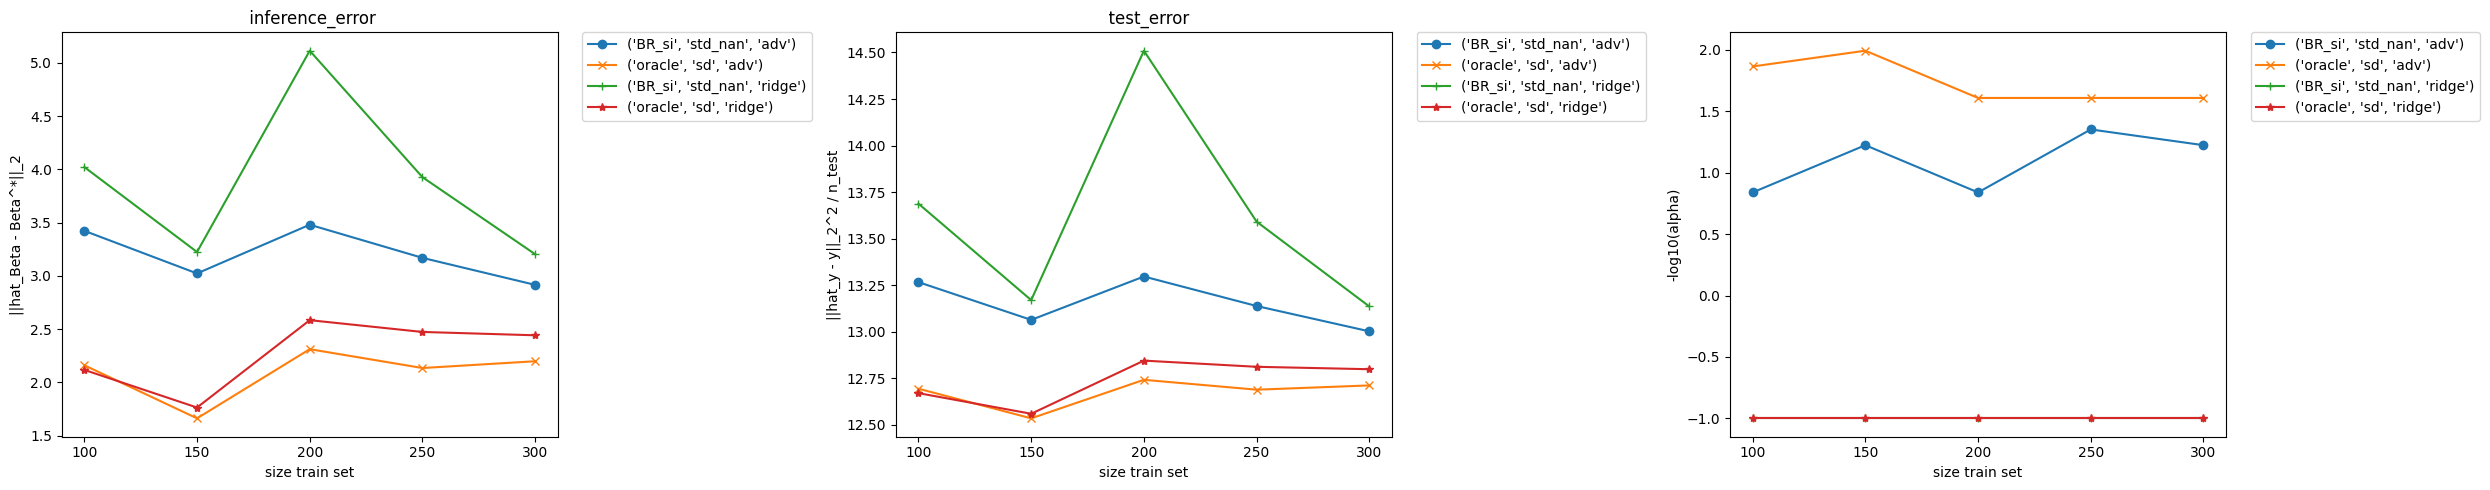

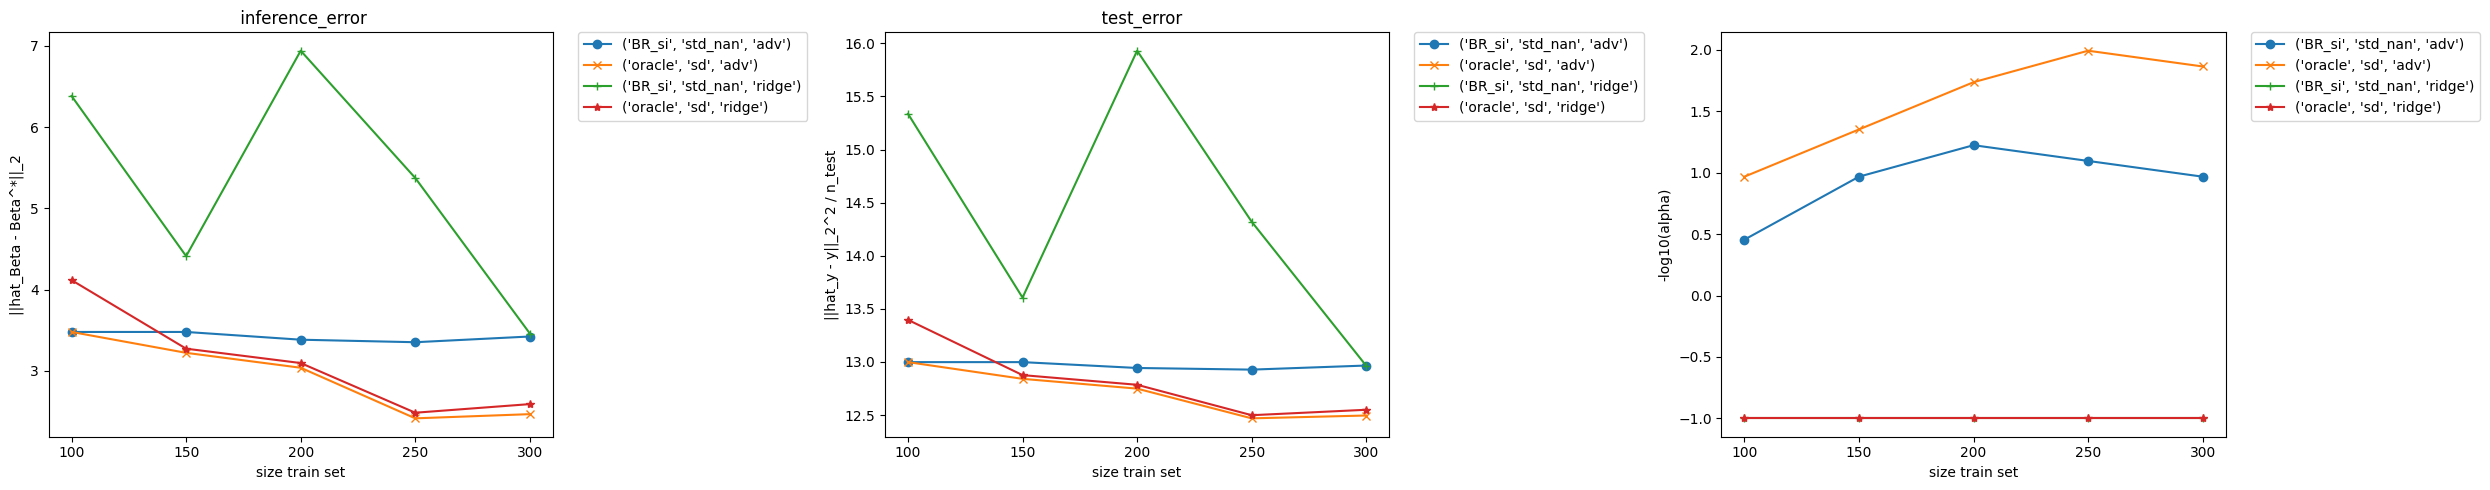

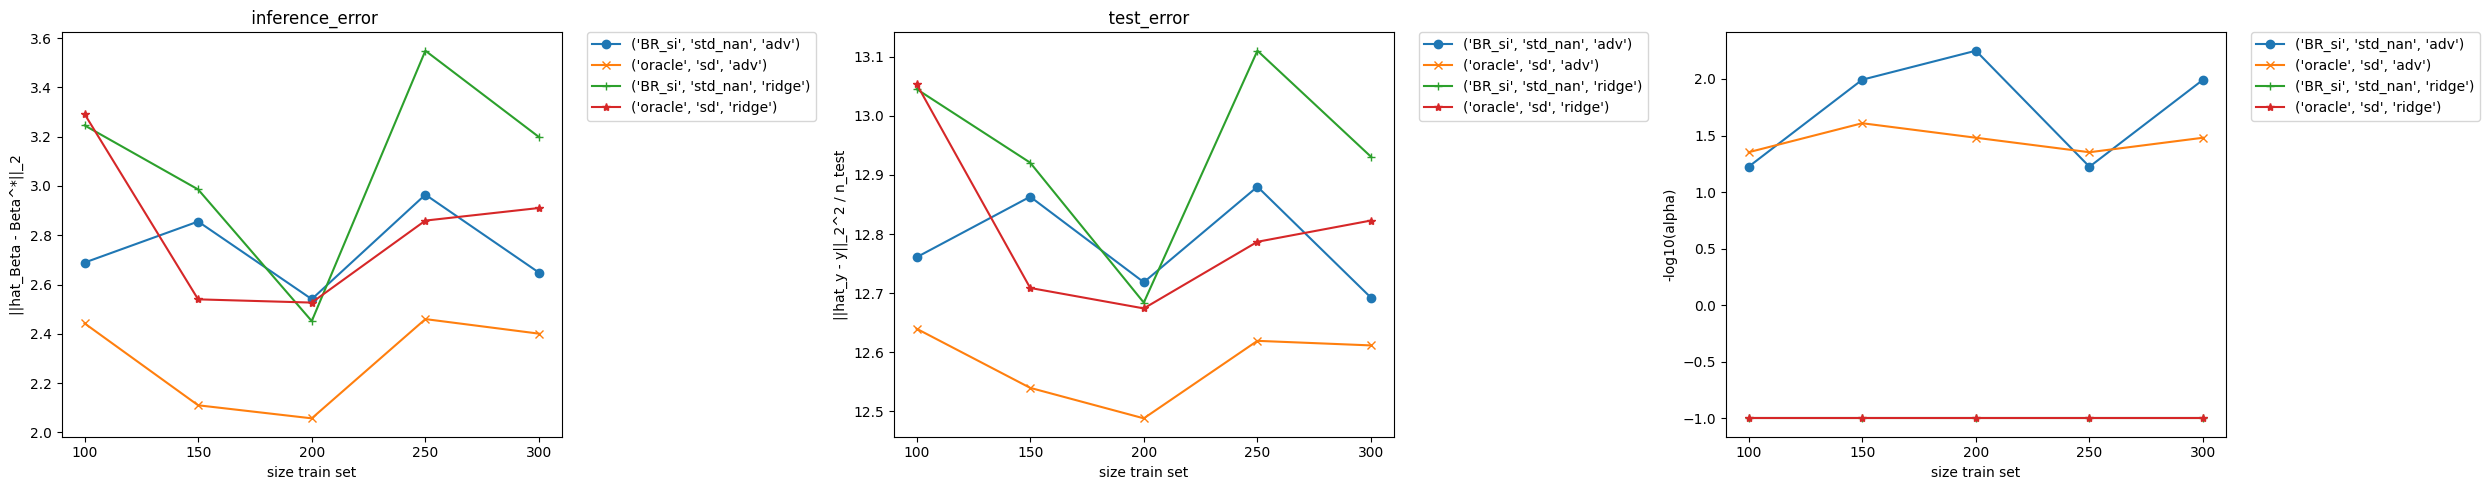

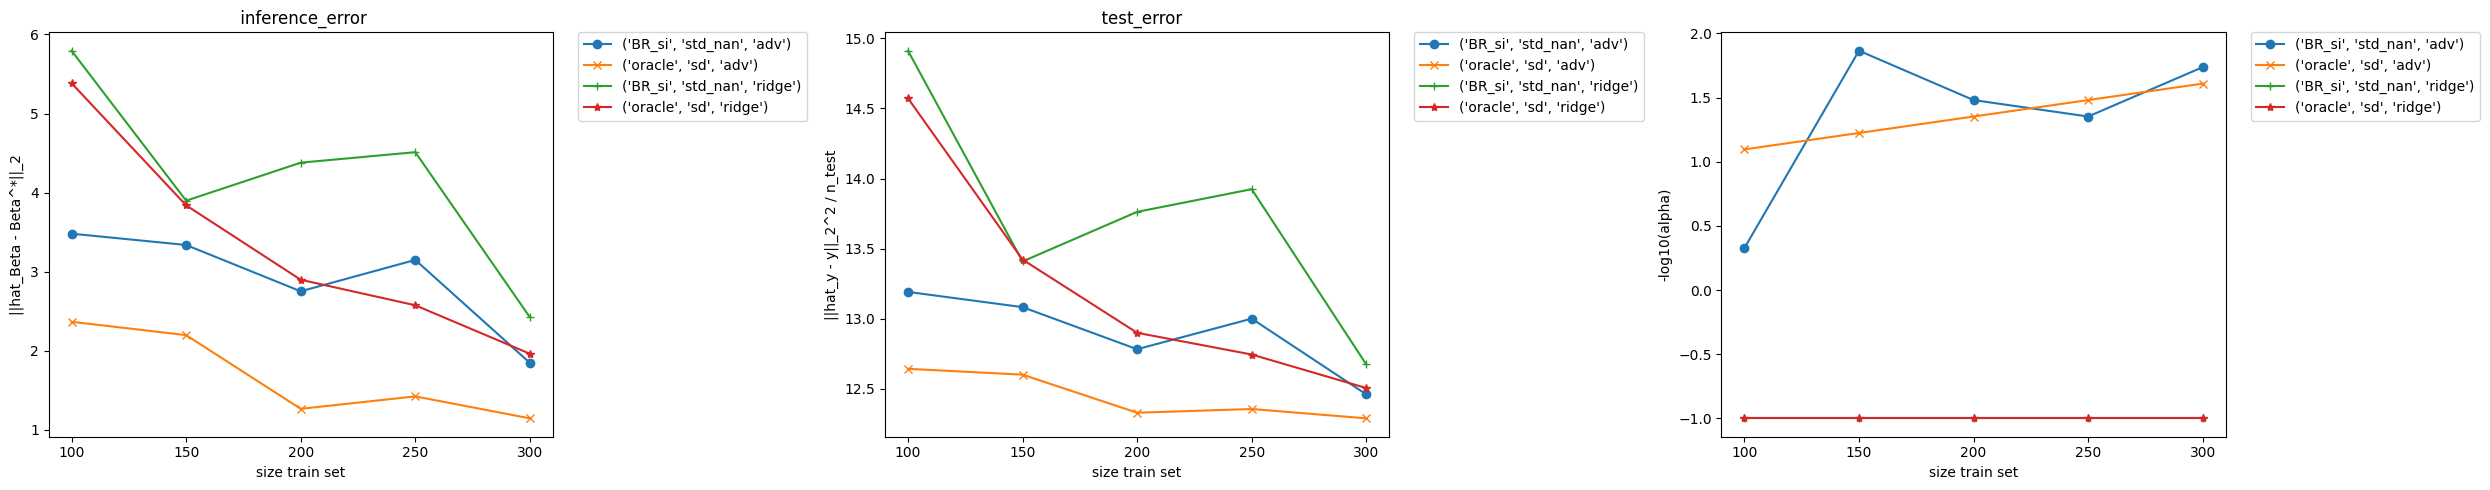

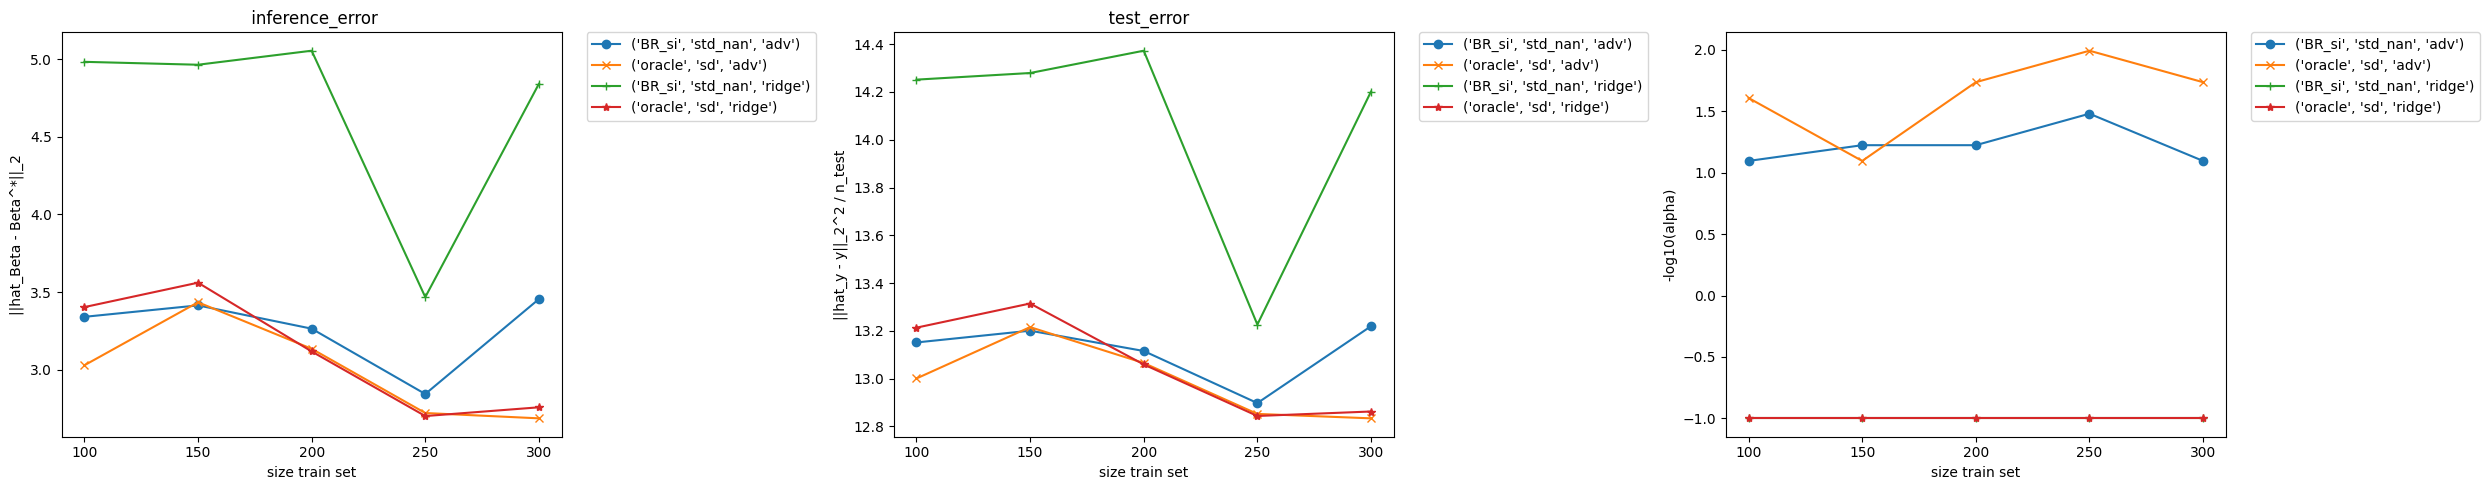

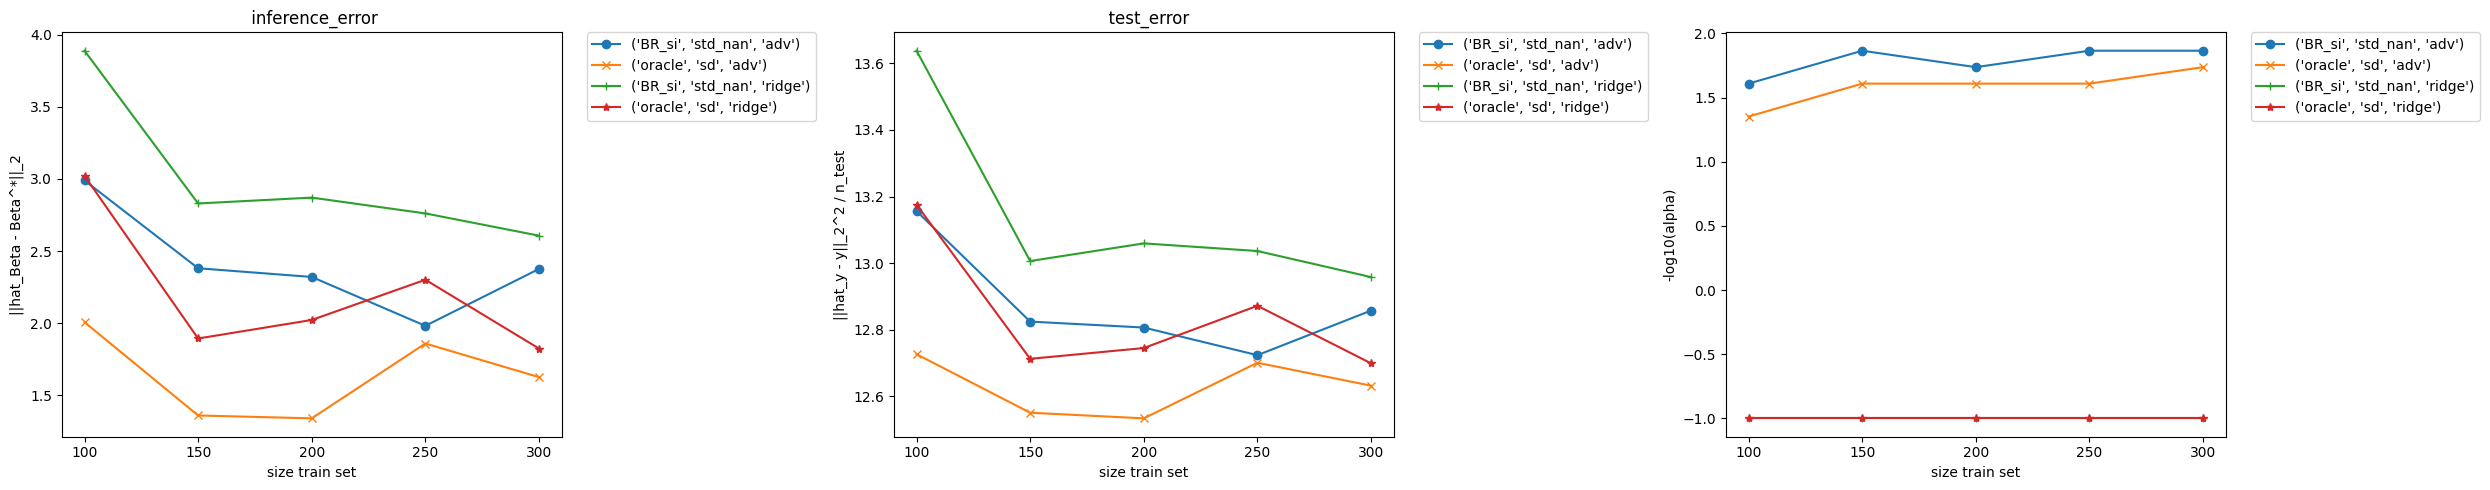

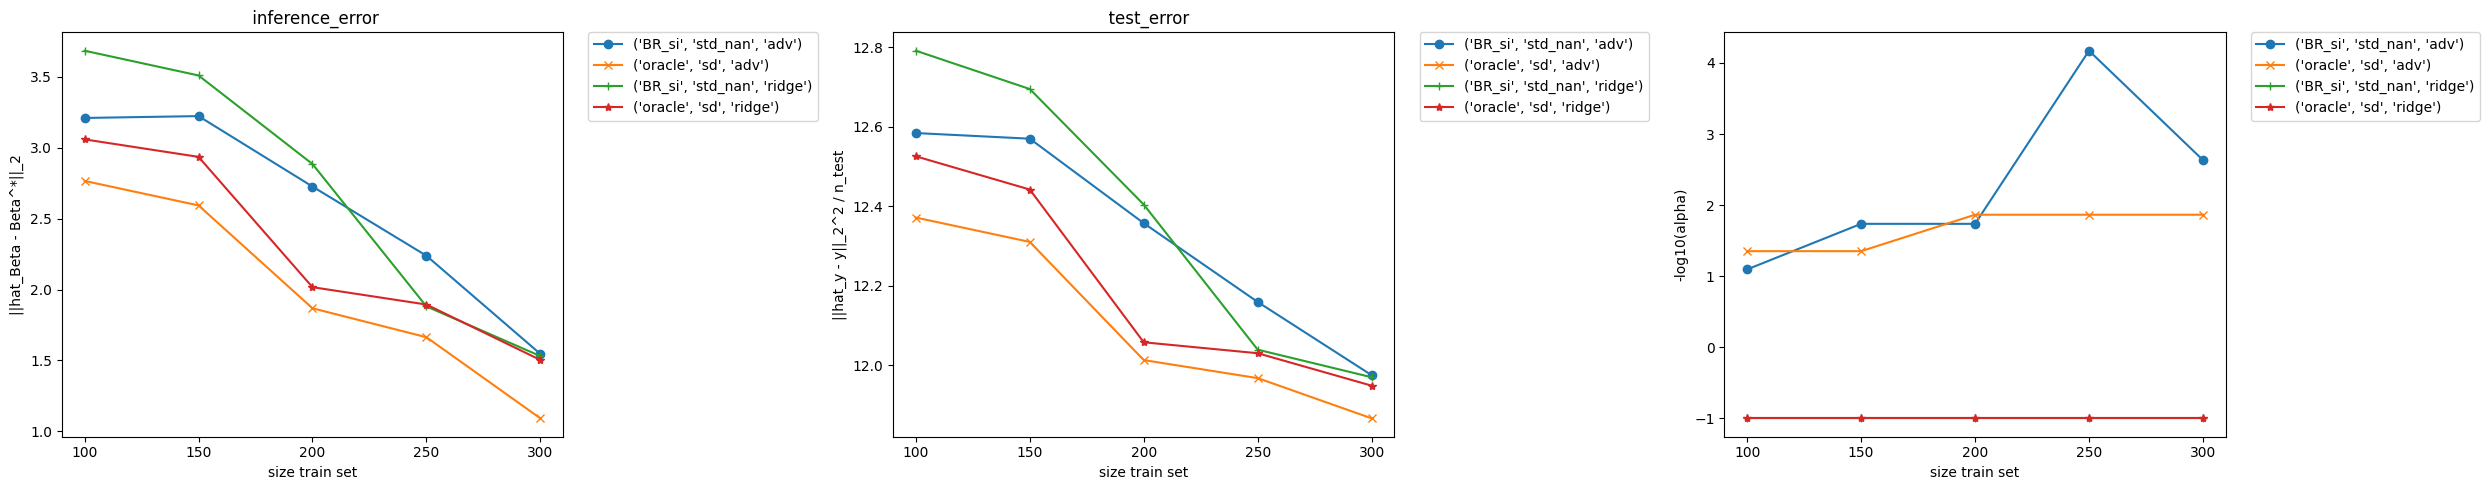

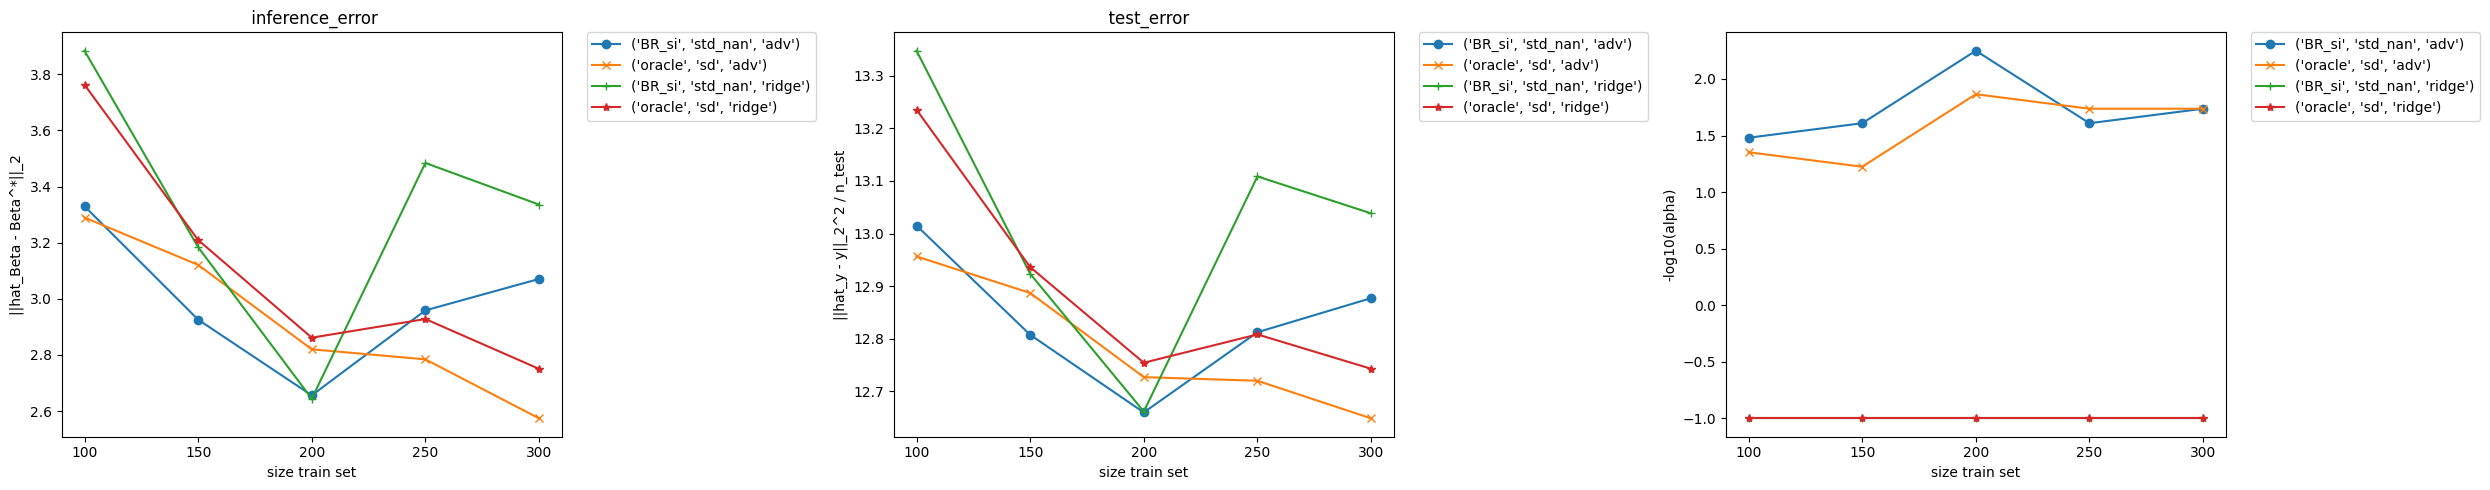

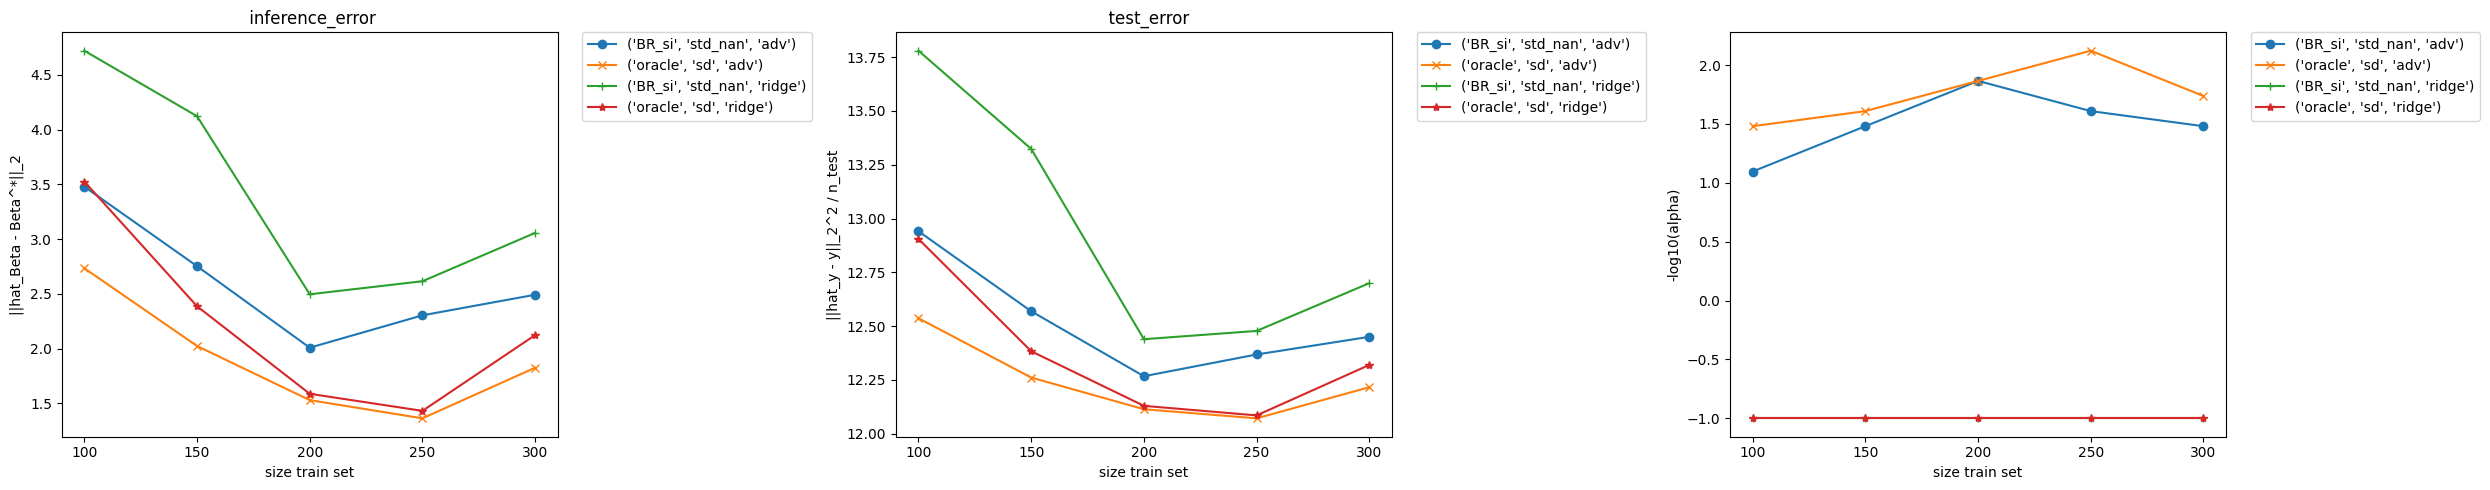

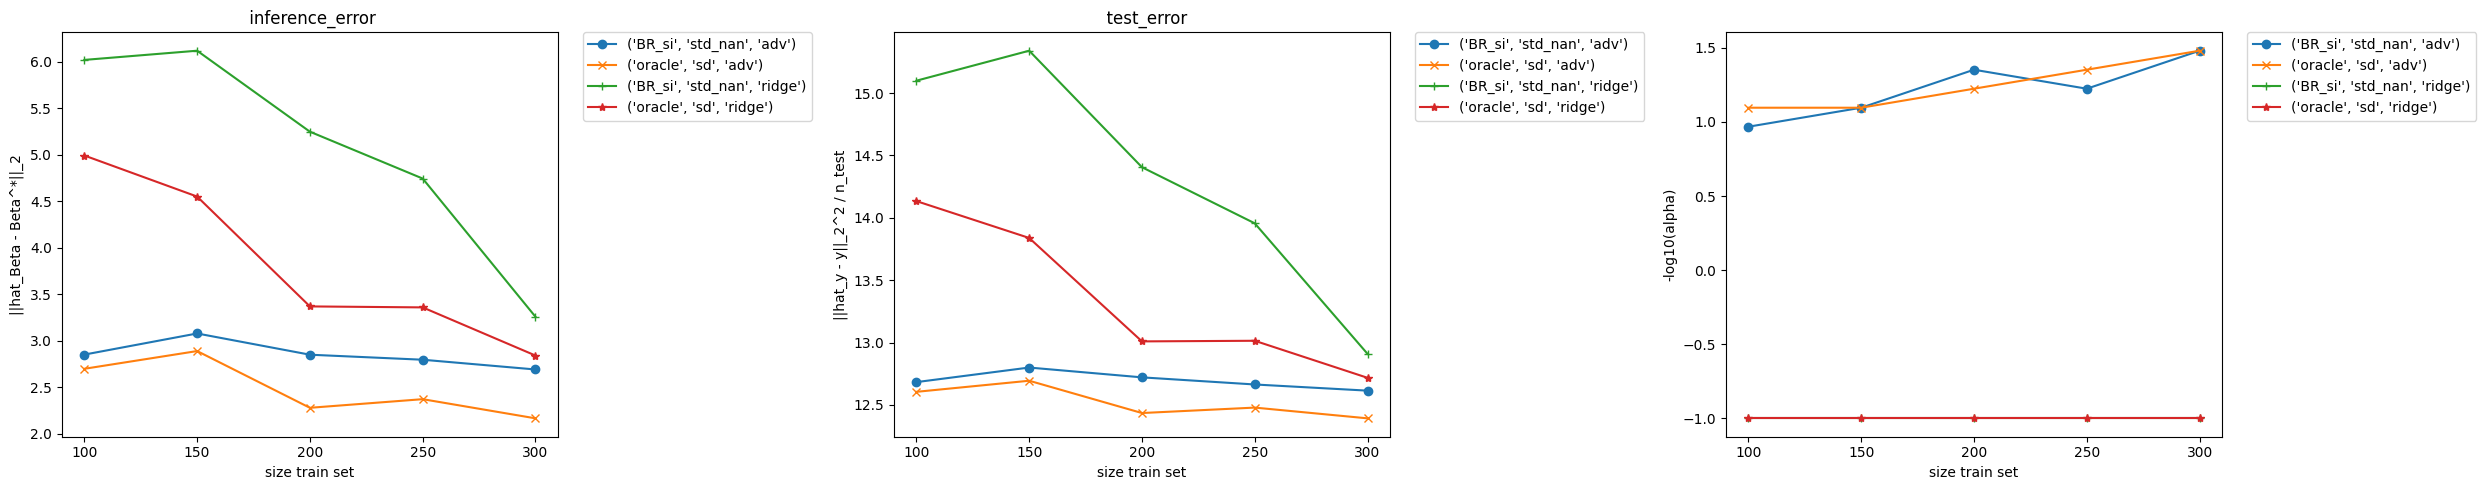

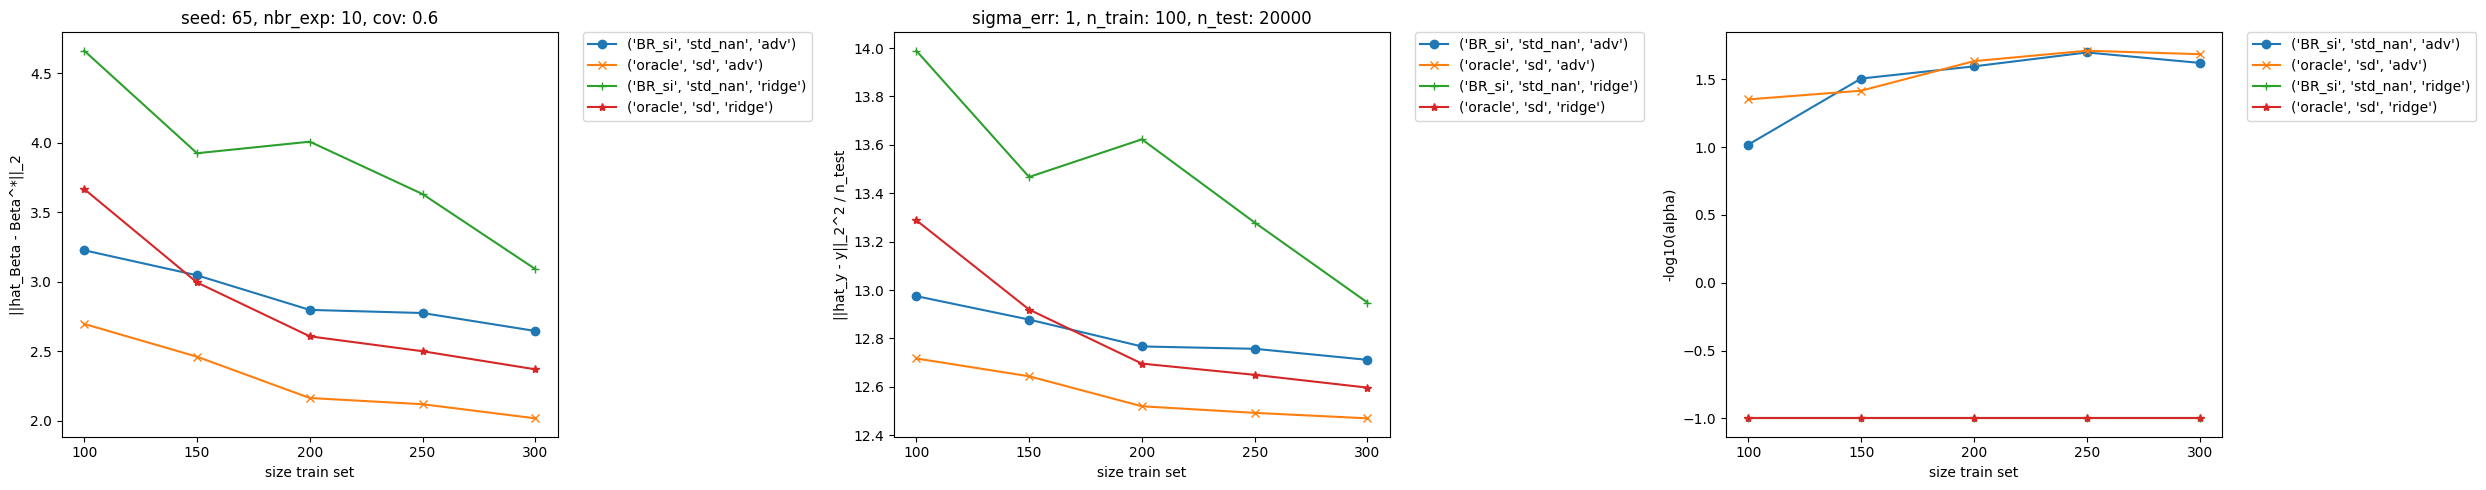

In [37]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):
gen = 'fixed'
info_axis = 'train'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6]
#p_seen_both = [1, 0.9, 0.8/0.9, 0.7/0.8, 0.6/0.7, 0.5/0.6, 0.4/0.5, 0.3/0.4]
n_train = [100, 150, 200, 250, 300]  # check how dataset are generated, there should be some problems with 'fixed'
lenght_vec = len(n_train)
p_seen_both = [0.6, 1, 1, 1, 1, 1, 1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
error_vec =  [1] * length_vec
#p_seen = make_probabilities(p_seen_both)
p_seen = [p_seen_both] * length_vec
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = np.cumprod(p_seen_both)  # p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)
number_test = 20000
cov_var = 0.6
#beta_gt = np.array([-0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4, 5, 6, 7, 8])
#beta_gt = np.array([2, 4, -0.5, 2, 1, 3, -2, -3, 4, 0.5, 7, -9, -1, -2, -3, 4])
beta_gt = np.random.randn(12)
print(beta_gt)
dim = len(beta_gt)
mean = np.array([0] * dim)
matr = np.random.randn(dim, dim) * 2
cov = matr.T @ matr + np.eye(dim) * 0.1
# np.array([[1, cov_var], [cov_var, 1]])

dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=number_test,
    data = {'data': 'Uniform', 'mean': mean, 'cov': cov},
    beta_gt = beta_gt,
    p_miss = p_seen,
    err_vector = ['Gaussian_on_X', error_vec],
    plots = []#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
#dicc = dicc | {'generation':gen}
dicc = dicc | {'generation': gen, 'title_infer_error':' inference_error', 'title_test_error':'  test_error'}
dicc = dicc | {'info_algo': {'adv_rad_times_delta_dts_max': 10, 'adv_rad_times_delta_mis_max': 10, 'alpha_ridge_reg_max': 10,
                             'eps_adv_rad_times_delta_dts': 1e-5, 'eps_adv_rad_times_delta_mis': 1e-5, 'eps_alpha_ridge_reg': 1e-5,
                             'n_a_dts': 40, 'n_a_mis':5, 'n_a_rid': 40}}

for key, value in dicc.items():
  print(key, ": " , value)

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
# def get_path(X, y, estimator, amax, dts_max, mis_max, S_dict, eps_amax=1e-4, eps_dts_max=1e-3, eps_mis_max=1e-3, n_alphas=100, n_deltas_dts=2, n_deltas_mis=3):

list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'adv'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing':0},
                        #{'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 3, 'multip_missing':3},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'algo_superv_learn':'ridge'},#, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'adv'}, #, 'multip_dataset': 3, 'multip_missing': 3},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'algo_superv_learn':'ridge'}
                        #{'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi', 'cov_strategy': 'std_mi', 'mi_nbr': mi_nbr},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'conc', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr}#, 'multip_dataset': 3, 'multip_missing': 3}
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")

'''
nbr_exp = 2
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

rdm_seed = 4654321
np.random.seed(rdm_seed)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    print("--------------------------------------------------------------------------------------nbr_experiment external ---------------> ", i+2, "-", i+2, " ", i+2, "-", i+2, " ", i+2)
    #np.random.seed(rdm_seed * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
'''
nbr_exp = 10
seed = 65
mean_res = run_multiple_experiments(nbr_exp, seed, dicc, info_x_axis)
print("PLOT OF THE MEANS")
dicc['title_infer_error'] = 'seed: ' + str(seed) + ', nbr_exp: ' + str(nbr_exp) + ', cov: ' + str(cov_var)
dicc['title_test_error'] = 'sigma_err: ' + str(error_vec[0]) + ', n_train: ' + str(n_train[0]) + ', n_test: ' + str(number_test)
#dicc = dicc | {'generation':gen, 'title_infer_error':'mean_infer_error, rep: ' + str(nbr_exp), 'title_mean_error':'mean_test_error'}
plot_res(info_x_axis, mean_res, dicc)

## you can see if you manage to take the index i that maximize alpha




In [12]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


[[[4 2]
  [2 4]]

 [[4 2]
  [4 4]]]
[[4 2]
 [2 4]
 [4 2]
 [4 4]]
[[[3 2]
  [4 3]
  [4 2]]]
[[3 2]
 [4 3]
 [4 2]]
[[2 4]
 [4 4]
 [2 3]
 [2 2]
 [3 3]]
[2 4 4 4 2 3 2 2 3 3]
other
[3 2 3 3 2]
[3 2 3 3 2 3 2 3 3 2 3 2 3 3 2]
other mult
[[4 6]
 [4 6]
 [6 3]]
[[4 6]
 [4 6]
 [6 3]
 [4 6]
 [4 6]
 [6 3]
 [4 6]
 [4 6]
 [6 3]]


In [13]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

'\n## random forest imputer\nfrom sklearn.ensemble import RandomForestRegressor\nrf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)\n\nX_rf = single_imputation(X_nan, rf_estimator)\nprint(X_rf.shape)\nsd_rf = np.std(X_rf, axis=0)\nS_inv_rf = np.diag(1 / sd_rf)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std rf\n ", sd_rf)\nfig, ax = plt.subplots(num=\'advtrain_linf_rf\')\nlinfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)\nestimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_rf, ax)\n'

In [14]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

'\n## iterative imputer Bayesian Ridge\n\nfrom sklearn.linear_model import BayesianRidge\nbr_estimator = BayesianRidge()\n\nX_br = single_imputation(X_nan, br_estimator)\nsd_br = np.std(X_br, axis=0)\nS_inv_br = np.diag(1 / sd_br)\nprint("std_orig: \n", np.std(X_orig, axis=0))\nprint("std  br\n ", sd_br)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_br\')\nlinfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)\nestimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)\nplot_coefs_l1norm(coefs_advtrain_linf_br, ax)\n'

In [15]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

"\n## mean imputation\nfrom sklearn.impute import SimpleImputer\n\nimp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')\nX_mean = imp_mean.fit_transform(X_nan)\nsd_mean = np.std(X_mean, axis=0)\nprint(sd_mean)\nS_inv_mean = np.diag(1 / sd_mean)\n\nfig, ax = plt.subplots(num='advtrain_linf_mean')\nlinfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)\nestimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_mean, ax)\n"

In [16]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

'\n# imputation elliptic\n\nmu = np.nanmean(X_nan, axis=0)\nprint("means ", mu)\ndelta = np.mean(masks) # parameter missingness\nprint("delta ", delta)\nX_0 = np.nan_to_num(X_nan)\nprint("nbr obs", X_0.shape[0])\nS_ellp =  X_0.T @ X_0 / X_0.shape[0]\nS_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp\nprint("eig cov ", np.linalg.eigvalsh(S_ellp))\nX_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)\n#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance\nsd_inv_ellp = np.std(X_ellp, axis=0)\nprint("sd ellp", sd_inv_ellp)\n\nfig, ax = plt.subplots(num=\'advtrain_linf_ellp\')\nlinfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)\nestimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)\nalphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)\nplot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)\n'

TypeError: add_rectangles() takes 4 positional arguments but 5 were given

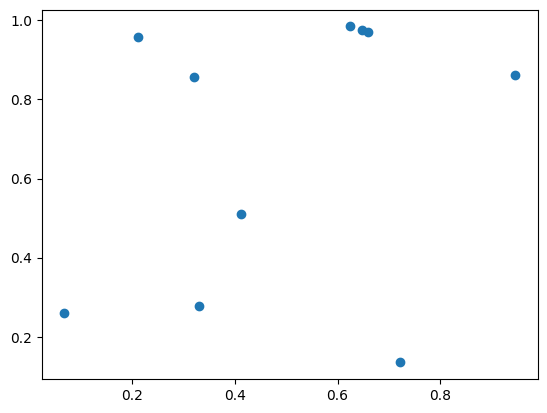

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))

print("new")

ls = [[[]],[[]]]
print(ls)
ls[0][0]



In [ ]:
import numpy as np

XX = np.random.randint(1, 7, (2, 3, 3))
print(XX)
XXX = np.tile(XX, (2, 1, 1))
print(XXX)

print(np.zeros(2))

y_o = np.array([1, 2])
y_oo = np.tile(y_o, 3)
print(y_oo)


In [ ]:
import numpy as np
def generate_masks_binomial_general(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks


#mm = np.random.binomial(1, [[0.2, 0.2, 0.2], [0.8, 0.8, 0.8]], (2, 3, 3))
#print(mm)
cc = np.array([np.random.binomial(1, x, (4, 4)) for x in [0.2, 0.2, 0.2]])
print(cc)
s_cc = np.cumsum(cc, axis=0)
print(s_cc)
s_cc[s_cc>1] = 1
print(s_cc)

s_v = np.random.randint(1, 4, (3, 4))
print(s_v)
s_vv = s_v[:, None, :] * np.eye(4)
print(s_vv)









In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import ridge_regression

X = np.random.randn(100, 4) #rng.randn(100, 4)

y = 2.0 * X[:, 0] - 1.0 * X[:, 1] + 0.1 * np.random.randn(100)
np.random.seed(4)
alphas = [0.00001, 0.001, 0.1, 1]
estim = lambda XX, yy, rad: ridge_regression(XX, yy, alpha=rad, return_intercept=False, random_state=0)
for a in alphas:
  #coef, intercept = estim(X, y, a)
  coef = estim(X, y, a)
  print("coef : ", coef)
  #print("intercpt ", intercept)
  coef, intercept = ridge_regression(X, y, alpha=a, return_intercept=True, random_state=0)
  #print("coef : ", coef)
  #print("intercpt ", intercept)




